---
**Análisis exploratorio de datos: *Pancreatic Cancer (PDAC vs Benigno)***

---

**Autor:** Acher Bizen Egido Mairal  
**Proyecto:** TFM - *Detección de enfermedades a través de modelos de clasificación multiclase aplicados a datasets de microARNs en biopsias líquidas*  
**Universidad Internacional de Valencia (VIU)**  
**Fecha de última modificación:** XX-XX-XXXX  
**Fuente de datos:** [GSE304572 - Circulating microRNAs in pancreatic cancer (NCBI GEO)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE304572)  

---
**Uso de Inteligencia Artificial en el desarrollo del código**

---
Este cuaderno ha sido elaborado combinando **desarrollo propio** con **asistencia de herramientas de Inteligencia Artificial**, empleadas de manera responsable y transparente.  
Durante la construcción del código se utilizaron principalmente **ChatGPT (OpenAI)** y **GitHub Copilot**, y en algunos casos **Claude (Anthropic)**, con el objetivo de:
- Generar estructuras base de código (funciones, pipelines, validaciones cruzadas, visualizaciones, etc.).  
- Explorar diferentes alternativas de implementación y optimización.  
- Solicitar aclaraciones teóricas y referencias para pasos metodológicos complejos o poco conocidos.

El flujo de trabajo relacionado con la IA consistió en:
1. Formular una misma consulta a dos IAs para contrastar enfoques.  
2. Seleccionar, validar y adaptar manualmente la mejor propuesta.  
3. Verificar el funcionamiento y exactitud del código a través de pruebas y búsqueda de documentación adicional.  

De este modo, la **IA se ha utilizado como herramienta de apoyo técnico y de aprendizaje**, no como sustituto del razonamiento ni del diseño metodológico.  
Todas las decisiones finales sobre preprocesamiento, modelado y análisis fueron tomadas por el autor tras validar los resultados empíricamente.


## **Librería de imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip, re
from scipy import stats
import seaborn as sns
import os

from pathlib import Path
from google.colab import drive
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
from collections import OrderedDict, Counter
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer,
    precision_recall_curve
)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.base import clone


# Instalación de UMAP
!pip install umap-learn
from umap import UMAP

## **Biblioteca de funciones**


In [ ]:
# Guarda un resumen compacto del DataFrame para el reporte.
def snapshot_df(df, name, notes=""):
    info = {
        "name": name,
        "shape": df.shape,
        "index_name": df.index.name,
        "columns_n": len(df.columns),
        "na_cells": int(df.isna().sum().sum()),
        "rows_with_na": int(df.isna().any(axis=1).sum()),
        "cols_with_na": int(df.isna().any(axis=0).sum()),
        "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,
        "notes": notes
    }
    audit_log.append(info)
    display(pd.DataFrame([info]))

# Resumen de una serie categórica (clases, etc.).
def snapshot_value_counts(ser, name, notes=""):
    vc = ser.value_counts(dropna=False).rename("count").to_frame()
    display(pd.DataFrame({"name":[name], "notes":[notes]}))
    display(vc)

# Informa de miARNs duplicados en el índice.
def miRNA_dup_report(df, name):
    dups = df.index.duplicated(keep=False)
    n_dup = dups.sum()
    print(f"[{name}] miARNs duplicados en índice: {n_dup}")
    if n_dup:
        display(df.index[dups].to_series().value_counts().head(20))

def columns_intersection_report(cols_a, cols_b, name_a="A", name_b="B"):
    set_a, set_b = set(cols_a), set(cols_b)
    inter = set_a & set_b
    only_a = set_a - set_b
    only_b = set_b - set_a
    print(f"[{name_a}∩{name_b}] comunes: {len(inter)} | solo {name_a}: {len(only_a)} | solo {name_b}: {len(only_b)}")
    if len(only_a):
        print(f"Ejemplos solo {name_a}:", list(sorted(only_a))[:5])
    if len(only_b):
        print(f"Ejemplos solo {name_b}:", list(sorted(only_b))[:5])
    return inter, only_a, only_b

def library_size_plot(expr_df, title="Tamaño de librería por muestra"):
    libsize = expr_df.sum(axis=0)
    plt.figure()
    libsize.sort_values().plot(kind="bar")
    plt.title(title)
    plt.ylabel("Suma de cuentas (por muestra)")
    plt.xlabel("Muestras (GSM)")
    plt.tight_layout()
    plt.show()

def zero_fraction_plots(expr_df, title_prefix="Fracción de ceros"):
    frac_zero_genes = (expr_df == 0).sum(axis=1) / expr_df.shape[1]
    frac_zero_samples = (expr_df == 0).sum(axis=0) / expr_df.shape[0]

    plt.figure()
    frac_zero_genes.hist(bins=30)
    plt.title(f"{title_prefix} por miRNA")
    plt.xlabel("Fracción")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    plt.figure()
    frac_zero_samples.hist(bins=30)
    plt.title(f"{title_prefix} por muestra")
    plt.xlabel("Fracción")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


In [ ]:
# =================================================================================================================================================
# Lee un txt/csv (posible .gz) con separador sep, usa la PRIMERA columna como índice (independientemente del nombre), y devuelve un DataFrame.
# =================================================================================================================================================
def read_firstcol_as_index(path, sep="\t"):
    df = pd.read_csv(path, sep=sep, header=0)
    df = df.set_index(df.columns[0])
    return df

# ============================================
# Homogeneiza nombres de miARN en el índice:
#    - a minúsculas
#    - elimina prefijo 'hsa-' si aparece
#    - recorta espacios
#    Devuelve df con índice normalizado.
# ===========================================
def normalize_mirna_index(df):
    new_idx = (
        df.index.astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r'^hsa-', '', regex=True)
    )
    df = df.copy()
    df.index = new_idx
    return df

# =====================================================
# Pasa de (miRNA x muestras) a (muestras x miRNA).
# =====================================================
def to_samples_x_features(expr_df):
    return expr_df.T.copy()


audit_log = []

## **Construcción del dataset**

In [ ]:
# =============================
# Montaje de Google Drive
# =============================
drive.mount('/content/drive')

base_path_pancreatic = "/content/drive/MyDrive/Máster BigData y ciencia de datos VIU/TFM/Datos/Pancreatic cancer"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Preparación del dataset de cáncer de páncreas**

Dimensiones matriz de expresión (miRNA x muestras): (2369, 85)


/tmp/ipython-input-3475677357.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,expr_df (crudo),"(2369, 85)",EnsgID,85,0,0,0,179836,miRNA x muestras


,112_487317,113_728178,114_1199351,68_352519,69_358213,70_326163,71_409727,72_414328,73_420668,74_423374,...,49_452396,50_675444,51_599428,61_601722,6B_125779,8A_1124865,96_1287495,97A_849688,98_107799,99_1205421
EnsgID,,,,,,,,,,,,,,,,,,,,,
miR-432-3p,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR-122-3p,0,0,0,0,0,1,3,0,5,1,...,0,1,10,30,4,0,5,1,0,0
miR-6129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,48_631346,59_794594,13A_531564,53_428465,45_1128045,8A_1124865,95_801159,30_683599,99_1205421,93_1179253
EnsgID,,,,,,,,,,
miR-126-5p,357,1386,835,541,6760,5693,9136,400,14230,2535
miR-223-3p,159,1746,291,602,8404,755,5298,66,16842,2805
miR-23a-3p,96,805,128,174,4043,1863,2730,112,7621,1092
miR-150-5p,215,397,561,312,2666,171,2215,527,2210,387
miR-191-5p,71,687,103,152,2837,215,1492,42,4498,873


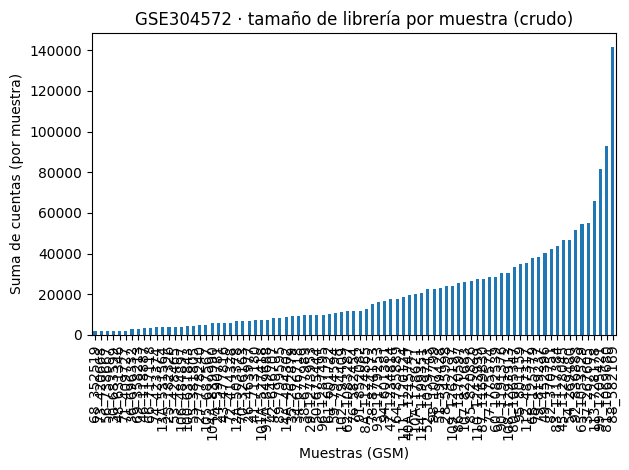

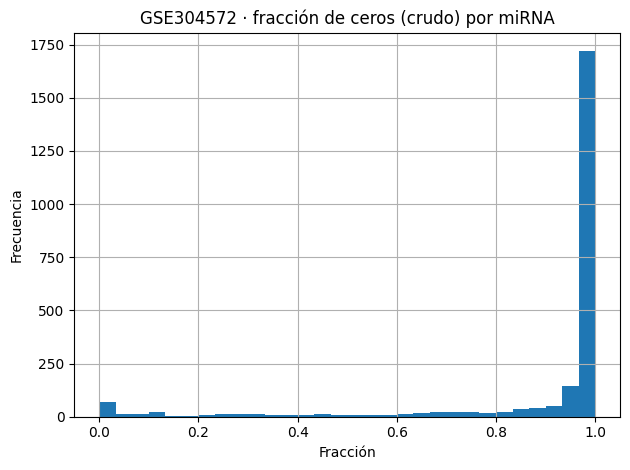

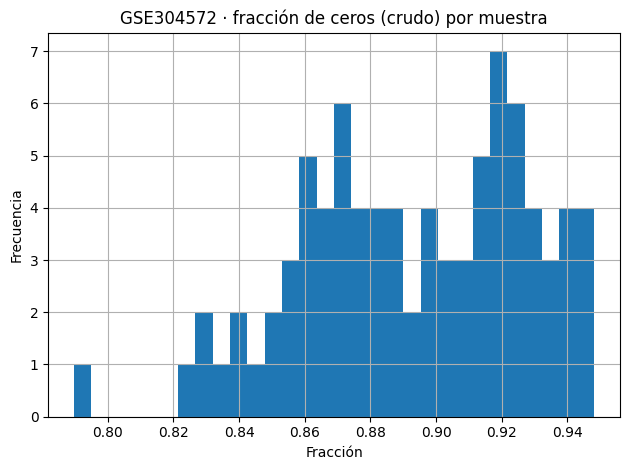

In [ ]:
# =============================
# Páncreas: expresión (xlsx)
# =============================
base_path = base_path_pancreatic
expr_file = f"{base_path}/GSE304572_processed_data.xlsx"

# La hoja "counts" tiene miARN en filas y las muestras en columnas
expr_df = pd.read_excel(expr_file, sheet_name="counts")

# Voy a utilizar la primera columna como índice
expr_df = expr_df.set_index(expr_df.columns[0])


# -------------------------------------------- METADATOS -----------------------------------------------
print("Dimensiones matriz de expresión (miRNA x muestras):", expr_df.shape)
snapshot_df(expr_df, "expr_df (crudo)", notes="miRNA x muestras")

# Vista rápida de 10 columnas aleatorias
display(expr_df.sample(n=3, axis=0, random_state=1))
display(expr_df.sample(n=10, axis=1, random_state=1).head(5))

# Figuras
library_size_plot(expr_df, title="GSE304572 · tamaño de librería por muestra (crudo)")
zero_fraction_plots(expr_df, title_prefix="GSE304572 · fracción de ceros (crudo)")



---

**Contenido de GSE304572_processed_data.xlsx**

---

La hoja de counts del cáncer de páncreas contiene la **matriz de expresión de miARNs**, con la siguiente estructura:
- **Filas (2.369)** --> Cada fila corresponde a un microARN.
- **Columnas (85)** --> Cada columna corresponde a una muestra/paciente.
- **Valores** --> Los valores corresponden con **cuentas crudas** de cada miRNA que hay en cada muestra, obtenidos de RNA-seq.

---

**Resultados de la exploración**

---

1.   **Tamaño de librería por muestra**
  - **Eje X**: Número total de lecturas asignadas en una muestra.
  - **Eje Y**: Suma total de cuentas por muestra.
  - **Interpretación**: Se observa una *gran variabilidad* (alguna muestras no superan las 10.000 lecturas, mientras que otras alcanzan más de 140.000). Esta heterogeneidad es **normal en RNA-seq**, pero implica que **posteriormente habrá que normalizar** (CPM, TMM, DESeq2 size factors) para hacer comparables las muestras.
  **No parece que haya 'outliers extremos'** que se deban descartar de inmediato, aunque igual hay que tratar algunas **muestras con menores lecturas para que no aporten mucho ruido**.

2.   **Fracción de ceros por miRNA**
  - **Eje X**: Proporción de muestras en las que el miRNA tiene conteo 0.
  - **Eje Y:** Número de miRNAs que cumplen esa proporción.
  - **Interpretación**: El resultado muestra que **la mayoría de miRNAs (>70%) están ausentes en casi todas las muestras (fracción ≈ 1.0)**. Esto refleja la biología de los **EV-miRNA**: muchos son de muy baja abundancia. Esto implica que habrá que aplicar un **filtrado de baja abundancia**, conservando solo aquellos miRNAs expresados en al menos X% de las muestras (criterio típico: CPM > 1 en ≥ 20% de las muestras). Reduciendo así el ruido y mejorando la robustez del modelo.

3. **Fracción de ceros por muestra**
  - **Eje X**: Fracción de ceros por muestra.
  - **Eje Y**: Frecuencia de muestras con esa fracción.
  -**Interpretación**: **En cada muestra, entre 80% y 95% de los miRNAs están a cero**. Esto indica que solo un subconjunto pequeño de miRNAs es realmente detectable en plasma EVs. Corroborando así que el **filtrado de baja abundancia es necesario**, y alerta de que hay **alta dispersión biológica**.



**Posible texto para la memoria**

---

**Exploración inicial de los datos**

La matriz de expresión contiene 2.369 miRNAs y 85 muestras (65 cáncer pancreático y 20 benignos). Los valores corresponden a **cuentas crudas de lecturas de RNA-seq en vesículas extracelulares de plasma**.

Se ha evaluado el tamaño de librería por muestra, observándose una marcada heterogeneidad entre ellas, con sumas totales de lecturas que oscilaban entre menos de 10.000 y más de 140.000. Este resultado indica la **necesidad de aplicar un método de normalización que corrija dichas diferencias técnicas**.

Por otra parte, se ha calculado la fracción de ceros tanto a nivel de miRNA como de muestra. La mayoría de los miRNAs aparecen no expresados en casi todas las muestras, lo que refleja la **baja abundancia típica en este tipo de material biológico**. Asimismo, cada muestra presenta entre un 80% y un 95% de ceros en sus perfiles, lo que sugiere que solo un subconjunto reducido de miRNAs es realmente detectable.

Estos análisis justifican la **necesidad de realizar un filtrado de baja abundancia y una normalización posterior antes de aplicar cualquier modelo de clasificación**.

In [ ]:
# ===================================================
# Páncreas: metadatos (soft.gz) -> DataFrame
# ===================================================
meta_file = f"{base_path}/GSE304572_family.soft.gz"

records = []
cur = {"gsm": None, "title": [], "chars": [], "desc": []}

# Función para 'cerrar' un bloque de muestra
def flush_block_pancreas(cur, records):
    if not cur["gsm"]:
        return
    text_full = " ".join(cur["title"] + cur["chars"] + cur["desc"])
    text_l = text_full.lower()

    # Las palabras clave por las que voy a clasificar son:
    #       pdac o pancreatic cancer            = PancreasCancerMaligno
    #       ipmn                                = PancreasCancerBenigno
    #       chronic pancreatitis o pancreatitis = PancreasCancerBenigno
    label = None
    if ("pdac" in text_l) or ("pancreatic cancer" in text_l) or re.search(r"\bcancer\b", text_l):
        label = "PancreasCancerMaligno"
    elif "ipmn" in text_l or "chronic pancreatitis" in text_l or re.search(r"\bpancreatitis\b", text_l):
        label = "PancreasCancerBenigno"

    # Intenta extraer un "core" tipo Patient: XXX o Library name: XXX
    code = None
    m1 = re.search(r"Patient:\s*([A-Za-z0-9_+\-]+)", text_full, flags=re.I)
    if m1: code = m1.group(1)
    m2 = re.search(r"Library name:\s*([A-Za-z0-9_+\-]+)", text_full, flags=re.I)
    if not code and m2: code = m2.group(1)
    core = code.split("-", 1)[0] if code else None

    # Me guardo los registros encontrados
    records.append({
        "GSM": cur["gsm"],
        "label": label,
        "patient_code": code,
        "patient_core": core
    })

with gzip.open(meta_file, "rt") as fh:
    for raw in fh:
        line = raw.strip()
        if line.startswith("^SAMPLE ="):
            flush_block_pancreas(cur, records)
            cur = {"gsm": line.split("= ")[1], "title": [], "chars": [], "desc": []}
        elif line.startswith("!Sample_title"):
            cur["title"].append(line.split("=", 1)[1].strip())
        elif line.startswith("!Sample_characteristics_ch1"):
            cur["chars"].append(line.split("=", 1)[1].strip())
        elif line.startswith("!Sample_description") or line.startswith("!Sample_data_processing"):
            cur["desc"].append(line.split("=", 1)[1].strip())
flush_block_pancreas(cur, records)

# -------------------------------------------- METADATOS -----------------------------------------------
meta_pancreas = pd.DataFrame.from_records(records)
print("Metadatos páncreas:", meta_pancreas.shape)
display(meta_pancreas.head(3))
print(meta_pancreas["label"].value_counts(dropna=False))

Metadatos páncreas: (85, 4)


,GSM,label,patient_code,patient_core
0,GSM9153034,PancreasCancerMaligno,100_631843-G-S,100_631843
1,GSM9153035,PancreasCancerMaligno,101A_527418-J-G,101A_527418
2,GSM9153036,PancreasCancerMaligno,102_794409-T-W,102_794409


label
PancreasCancerMaligno    65
PancreasCancerBenigno    20
Name: count, dtype: int64


---
**Contenido de GSE304572_family.soft.gz**

---
Los ficheros 'soft', son típicos ficheros de GEO en formato SOFT, que contienen información de cada muestra (SAMPLE) con título, características clínicas y descripciones.

En este caso he extraido la siguiente infroamción:

*   **GSM:** Identificador único de la muestra en GEO.
*   **label**: Como el objetivo del estudio es saber clasificar entre enfermedades malignas (cánceres primordialmente) y enfermedades benignas, he decido hacer la sigueinte clasificación::
    *   "**PancreasCancerMaligno**" → pacientes con cáncer pancreático (PDAC).
    *   "**PancreasCancerBenigno**" → pacientes con IPMN o pancreatitis crónica.
*   **patient_code**: Código extraído de los metadatos (p. ej. 100_631843-G-S).
*   **patient_core**: Versión simplificada del código (ej. 100_631843), que uso más adelante como clave para enlazar con la matriz de expresión.





In [ ]:
# =============================
# Páncreas: preparar X,y
# =============================

# Normaliza los nombres de miARN
#   - Pasa todo a minúsculas.
#   - Eliminar los prefijos 'hsa-' si aparecen.
#   - Recorta los espacios.
expr_pancreas = normalize_mirna_index(expr_df)

# Vector de etiquetas (voy a utilizar 'patient_core' como columna)
expr_cols = expr_pancreas.columns.tolist()
code2label = dict(zip(meta_pancreas["patient_core"], meta_pancreas["label"]))

faltan_en_meta = [c for c in expr_cols if c not in code2label]
print("Columnas sin etiqueta en metadatos (muestra):", faltan_en_meta[:5])

# Construyo X (muestras x miRNA) e Y (etiquetas finales del estudio de páncreas)
X_pancreas = to_samples_x_features(expr_pancreas)
y_pancreas = [code2label.get(c, None) for c in X_pancreas.index]

print("X_pancreas:", X_pancreas.shape)
pd.Series(y_pancreas).value_counts(dropna=False)


Columnas sin etiqueta en metadatos (muestra): []
X_pancreas: (85, 2369)


,count
PancreasCancerMaligno,65
PancreasCancerBenigno,20


---
**Transformaciones realizadas**

---

1.   **Clasificación automática con expresiones regulares:** Busco en el texto palabras y las asigno a los tipos de cánceres correspondientes (malignos o benignos):
     - "pdac", "pancreatic cancer", "cancer" → **PancreasCancerMaligno**.
     - "ipmn", "chronic pancreatitis", "pancreatitis" → **PancreasCancerBenigno**.

2.   **Extracción de identificadores de paciente** Con regex busco patrones para generar *patient_code* y *patient_core*, que posteriormente relacionaré con los ids de la matriz de expresión.
3. **Construcción de X e Y**
    - *X_pancreas*: Es un dataframe con **85 muestras x 2369 miRNAs** (transpuesta de la matriz original para trabajar en formato scikit-learn).
    - *y_pancreas*: Es una **lista de etiquetas** (PancreasCancerMaligno o PancreasCancerBenigno) alineadas con X.

También he verificado que todas las columnas de la matriz (expr_cols) aparezcan en los metadatos, en este caso no falta ninguna etiqueta.



meta_pancreas_min: (85, 4)


,sample_id,label,dataset,matrix_type
0,112_487317,PancreasCancerBenigno,GSE304572,plasma_total
1,113_728178,PancreasCancerBenigno,GSE304572,plasma_total
2,114_1199351,PancreasCancerBenigno,GSE304572,plasma_total


label
PancreasCancerMaligno    65
PancreasCancerBenigno    20
Name: count, dtype: int64


/tmp/ipython-input-3475677357.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,meta_pancreas_min,"(85, 4)",None,4,0,0,0,None,Dataset reducido para el modelado


,name,notes
0,Distribución de clases (meta_min),


,count
label,
PancreasCancerMaligno,65
PancreasCancerBenigno,20


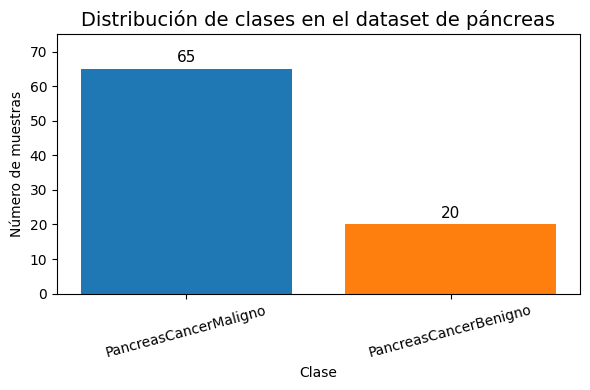

In [ ]:
# ===================================================
# Páncreas: Preparación de los metadatos mínimos
# ===================================================
meta_pancreas_min = pd.DataFrame({
    "sample_id": X_pancreas.index.astype(str),   # Uso el índice de X_pancreas
    "label": y_pancreas,
    "dataset": "GSE304572",
    "matrix_type": "plasma_total"
})

# -------------------------------------------- METADATOS -----------------------------------------------
print("meta_pancreas_min:", meta_pancreas_min.shape)
display(meta_pancreas_min.head(3))
print(meta_pancreas_min["label"].value_counts())
snapshot_df(meta_pancreas_min, "meta_pancreas_min", notes="Dataset reducido para el modelado")
snapshot_value_counts(meta_pancreas_min["label"], "Distribución de clases (meta_min)")

# ===================================================
# Gráfica de desbalanceo de clases
# ===================================================
class_counts = meta_pancreas_min["label"].value_counts()

plt.figure(figsize=(6,4))
bars = plt.bar(class_counts.index, class_counts.values, color=["#1f77b4", "#ff7f0e"])
plt.title("Distribución de clases en el dataset de páncreas", fontsize=14)
plt.ylabel("Número de muestras")
plt.xlabel("Clase")
plt.xticks(rotation=15)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
             ha='center', va='bottom', fontsize=11)

plt.ylim(0, class_counts.max() + 10)
plt.tight_layout()
plt.savefig("pancreas_class_balance.png", dpi=300)
plt.show()


---
**Contenido de meta_pancreas_min**

---

El dataset *meta_pancreas_min* contiene las siguientes columnas:
- **sample_id**: Nombre de la muestra.
- **label**: La clase asignada (PancreasCancerBenigno o PancreasCancerMaligno).
- **dataset**: "GSE304572".
- **matrix_type**: "plasma_total".

---
**Resultados finales**

---
- **Metadatos**: Hay 85 registros, perfectamente emparejados con la matriz de expresión.
- **Distribución de clases**:
  - PancreasCancerMaligno: 65 muestras.
  - PancreasCancerBenigno: 20 muestras.

Existe un **claro desbalanceo de clases** (76% vs 24%). Esto es relevante porque más adelante seguramente necesite equilibrarlas de alguna manera:
  - Utilizando estratificación en train/test splits.
  - Con métricas robustas a desbalance (ROC-AUC, PR-AUC, F1 macro).
  - Posible uso de class_weight o técnicas de rebalanceo.

---
**Posible texto para la memoria**

---
**Construcción del dataset de trabajo**

A partir del fichero de metadatos en formato SOFT (GSE304572_family.soft.gz), se ha extraido la **información clínica y técnica asociada a cada muestra**. Mediante expresiones regulares sobre las descripciones y características, se han asignado etiquetas de clase binarias: **PancreasCancerMaligno (pacientes con adenocarcinoma ductal de páncreas, PDAC) y PancreasCancerBenigno (pacientes con IPMN o pancreatitis crónica)**.

Además, se han identificado los códigos de paciente a partir de campos como *Patient* o *Library name*, lo que permite **emparejar sin ambigüedades las muestras clínicas con las columnas de la matriz de expresión**. El resultado es una matriz *X_pancreas* de dimensión **85 muestras × 2369 miRNAs** y un vector de etiquetas *y_pancreas* con la condición clínica correspondiente.

Finalmente, se ha creado un conjunto mínimo de metadatos con los campos *sample_id*, *label*, *dataset* y *matrix_type*, útil para el seguimiento y análisis posterior. La **distribución de clases es desbalanceada (65 malignos frente a 20 benignos)**, hecho que se ha tenido en cuenta en el diseño de los experimentos de validación y en la selección de métricas de evaluación.

## **Preprocesado del dataset de Cáncer de páncreas**

---
**Filtrado de baja abundancia (antes de normalizar)**

---
Como tengo conteos crudos muy dispersos en tamaño de librería y con ~89% de ceros por miRNA, la idea es **eliminar miRNAs que casi nunca están detectados (ruido) sin perder marcadores que puedan ser específicos de clase** (p.ej., presentes sobre todo en PDAC).

Voy a seguir los siguientes criterios:
1. **Definición de 'detectado'**: La idea es utilizar los conteos crudos para decidir la presencia o no (evitando que el umbral dependa del tamaño de la librería). En este caso he probado con varios valores:
  - **Mayor o igual a 1** --> Es demasiado laxo.
  - **Mayor o igual a 3** --> Me sirve para reducir falsos positivos.
  - **Mayor o igual a 5** --> Es demasiado conservador.

2. **Prevalencia mínima**: La idea es conservar el miRNA se está presente en un umbral determinado, en este caso he tenido en cuenta dos aspectos:
  - **Que esté dentro de un umbral determinado de las muestras.**
  - **Que esté en un umbral determinado dentro de al menos una clase**

---
**Posible texto para la memoria**

---
**Filtrado de baja abundancia**:

Con el fin de reducir ruido propio de perfiles de miRNA en vesículas extracelulares (alto porcentaje de ceros), se definió *presencia* a nivel de muestra como conteos ≥3 (umbral conservador para evitar lecturas espurias). Se retuvieron aquellos miRNAs presentes en ≥20% de las muestras o, para no penalizar señales específicas de clase, en ≥20% de alguna de las clases (PDAC o benigno).

In [ ]:
# =========================================
# Filtrado de baja abundancia (Pancreas)
# =========================================
PRESENCE_THRESHOLD = 3       # conteos >=3 lo considero "presencia"
MIN_PREV_GLOBAL = 0.20       # ≥20% de muestras
MIN_PREV_PER_CLASS = 0.20    # ≥20% dentro de al menos una clase (PDAC o Benigno)

expr_counts_pancreas = expr_df.copy()     # miRNA x muestras (counts)
meta_pancreas = meta_pancreas_min.copy()
meta_pancreas = meta_pancreas.loc[meta_pancreas['sample_id'].isin(expr_counts_pancreas.columns)].copy()

# Reordeno las columnas de expr_counts_pancreas para que coincidan con meta
expr_counts_pancreas = expr_counts_pancreas.loc[:, meta_pancreas['sample_id'].tolist()]

# Etiquetas por muestra
labels_pancreas = pd.Series(meta_pancreas['label'].values,
                            index=meta_pancreas['sample_id'].values,
                            name='label')

# Matriz booleana de presencia
presence_pancreas = (expr_counts_pancreas >= PRESENCE_THRESHOLD)

# Prevalencia global
prev_global_pancreas = presence_pancreas.sum(axis=1) / presence_pancreas.shape[1]

# Prevalencia por clase
classes = labels_pancreas.unique()
prev_by_class_pancreas = {}
for cls in classes:
    cols_cls = labels_pancreas.index[labels_pancreas == cls]
    if len(cols_cls) == 0:
        continue
    prev_by_class_pancreas[cls] = presence_pancreas[cols_cls].sum(axis=1) / len(cols_cls)

# Máscara final de retención
mask_keep_pancreas = prev_global_pancreas >= MIN_PREV_GLOBAL
for cls, prev_s in prev_by_class_pancreas.items():
    mask_keep_pancreas = mask_keep_pancreas | (prev_s >= MIN_PREV_PER_CLASS)

expr_counts_filt_pancreas = expr_counts_pancreas.loc[mask_keep_pancreas].copy()

print(f"[Filtrado · Pancreas] miRNA totales: {expr_counts_pancreas.shape[0]}  → retenidos: {expr_counts_filt_pancreas.shape[0]} "
      f"(umbral presencia ≥{PRESENCE_THRESHOLD}, prevalencia ≥{int(MIN_PREV_GLOBAL*100)}% global "
      f"o ≥{int(MIN_PREV_PER_CLASS*100)}% en alguna clase)")


[Filtrado · Pancreas] miRNA totales: 2369  → retenidos: 230 (umbral presencia ≥3, prevalencia ≥20% global o ≥20% en alguna clase)


---
**Normalización tras el filtrado**

---
Para la normalización voy a seguir los siguientes pasos:
1. **Escalado por tamaño de librería**: Como luego voy a fusionar este dataset con otros que ya están en escalas RPM/TPM (mama) y log2-like (renal), CPM/RPM + log deja todo en una base comparable. Voy a calcular el **CPM** o **RPM** por cada muestra. En vez de aplicar otros métodos como **TMM (edgeR)** o **size factors (DESeq2)**
2. **Transformación logarítmica**: Para **estabilizar la varianza** y evitar que unos pocos miRNAs muy abundantes dominen en la PCA/UMAP y hacer una escala comparable con los otros datasets (renal y mama), voy a aplicar la transforamción **log2(CPM + 1) (pseudo-count = 1).**


---
**Posible texto para la memoria**

---
**Normalización**:

Para corregir diferencias de profundidad de secuenciación entre muestras, los conteos se han transformado a **CPM (counts per million)** y posteriormente a escala logarítmica mediante **log2(CPM+1)**. Esta transformación estabiliza la varianza y la hace comparable con otros datasets (mama en TPM/RPM y renal ya en escala log2). La matriz log2-CPM se emplea para análisis posteriores (ComBat y modelado); para proyecciones no supervisadas (PCA/UMAP) se utilizó, cuando fue necesario, una versión centrada y estandarizada por miRNA exclusivamente a efectos de visualización.

In [ ]:
# ===========================================
# Normalización (CPM/RPM + log2) · Pancreas
# ===========================================

# CPM/RPM por muestra
lib_sizes_pancreas = expr_counts_filt_pancreas.sum(axis=0)  # suma por muestra
lib_sizes_pancreas = lib_sizes_pancreas.replace(0, np.nan)  # evito la división por cero

expr_cpm_pancreas = expr_counts_filt_pancreas.divide(lib_sizes_pancreas, axis=1) * 1e6

# log2(CPM + 1)
expr_logcpm_pancreas = np.log2(expr_cpm_pancreas + 1.0)

# Versiones principales
X_logcpm_features_by_samples_pancreas = expr_logcpm_pancreas.copy()   # miRNA x muestras
X_logcpm_samples_by_features_pancreas = expr_logcpm_pancreas.T        # muestras x miRNA

print("[Normalización · Pancreas] Escala log2(CPM+1):")
print(" - Matriz (miRNA x muestras):", X_logcpm_features_by_samples_pancreas.shape)
print(" - Matriz (muestras x miRNA):", X_logcpm_samples_by_features_pancreas.shape)


[Normalización · Pancreas] Escala log2(CPM+1):
 - Matriz (miRNA x muestras): (230, 85)
 - Matriz (muestras x miRNA): (85, 230)


## **Exploración del dataset**

En un primer lugar voy a utilizar técnicas de **reducción de la dimensionaliad**, para poder observar agrupaciones en los datasets con muchos datos.

1. **PCA (Principal Component Analysis)**: Busca combinaciones lineales de las variables originales (los 261 miARNs) que maximicen la varizanza explicada.

2. **UMAP (Uniform Manifold Approximation and Projection)**: Modela los datos como un grafo de proximidad (vecinos cercanos en el espacio de alta dimensión). Intenta preservar esas relaciones de vecindad al proyectar a 2D.


### **PCA exploratoria**

**Características de la PCA:**
- Es un **método lineal**, que **preserva la estructura global de los datos** (direcciones de mayor variabilidad).
- Cada eje (PC1, PC2) tiene una **cantidad clara de varianza explicada**.
- Permite relacionar directamente los componentes con combinaciones de miARNs.

**Limitaciones:**
    
- Si las separaciones entre clases están dadas por relaciones no lineales, puede no captarlas bien.
- Los gráficos PCA a veces muestran solapamiento fuerte aunque en el espacio original haya estructuras más complejas.

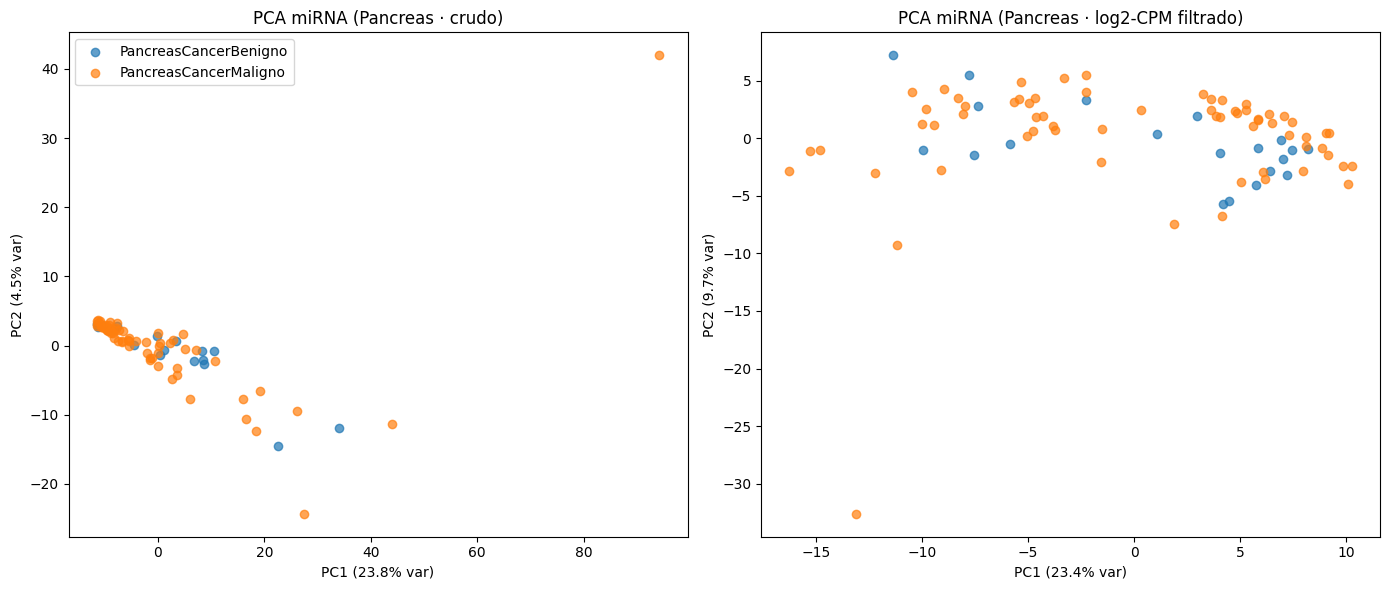

In [ ]:
# ==========================================================
# Comparativa PCA: crudo vs filtrado + normalizado (Pancreas)
# ===========================================================

# PCA con datos crudos
X_pancreas_raw = expr_pancreas.copy().T

scaler_raw = StandardScaler(with_mean=True, with_std=True)
X_pancreas_raw_scaled = scaler_raw.fit_transform(X_pancreas_raw)

meta_idx_pancreas = meta_pancreas_min.set_index("sample_id").copy()
meta_idx_pancreas.index = meta_idx_pancreas.index.astype(str)
labels_pancreas = meta_idx_pancreas["label"].reindex(X_pancreas_raw.index)

pca_raw = PCA(n_components=2, random_state=42)
X_pancreas_raw_pca = pca_raw.fit_transform(X_pancreas_raw_scaled)

pca_df_raw = pd.DataFrame(X_pancreas_raw_pca, columns=["PC1", "PC2"], index=X_pancreas_raw.index)
pca_df_raw["label"] = labels_pancreas.fillna("Unknown").values

# PCA con datos filtrados + normalizados (log2-CPM)
X_pancreas_norm = X_logcpm_samples_by_features_pancreas.copy()

scaler_norm = StandardScaler(with_mean=True, with_std=True)
X_pancreas_norm_scaled = scaler_norm.fit_transform(X_pancreas_norm)

labels_pancreas_norm = meta_idx_pancreas["label"].reindex(X_pancreas_norm.index)

pca_norm = PCA(n_components=2, random_state=42)
X_pancreas_norm_pca = pca_norm.fit_transform(X_pancreas_norm_scaled)

pca_df_norm = pd.DataFrame(X_pancreas_norm_pca, columns=["PC1", "PC2"], index=X_pancreas_norm.index)
pca_df_norm["label"] = labels_pancreas_norm.fillna("Unknown").values

# Gráficos comparativos
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# PCA crudo
for label, sub in pca_df_raw.groupby("label"):
    axes[0].scatter(sub["PC1"], sub["PC2"], alpha=0.7, label=label)
axes[0].set_xlabel(f"PC1 ({pca_raw.explained_variance_ratio_[0]*100:.1f}% var)")
axes[0].set_ylabel(f"PC2 ({pca_raw.explained_variance_ratio_[1]*100:.1f}% var)")
axes[0].set_title("PCA miRNA (Pancreas · crudo)")
axes[0].legend()

# PCA normalizado
for label, sub in pca_df_norm.groupby("label"):
    axes[1].scatter(sub["PC1"], sub["PC2"], alpha=0.7, label=label)
axes[1].set_xlabel(f"PC1 ({pca_norm.explained_variance_ratio_[0]*100:.1f}% var)")
axes[1].set_ylabel(f"PC2 ({pca_norm.explained_variance_ratio_[1]*100:.1f}% var)")
axes[1].set_title("PCA miRNA (Pancreas · log2-CPM filtrado)")

plt.tight_layout()
plt.show()


### **UMAP por enfermedad**


UMAP proyecta las muestras a 2D para ver si las clases biológicas forman clústeres separados. Detecta estructura no lineal que el PCA podría no mostrar.

**Características de UMAP:**
- Modelo no lineal
- Pone más énfasis en la estructura local (agrupa puntos que son vecinos).
- Produce representaciones 2D en las que los puntos que están cercanos en la gráfica suelen ser *parecidos* en los datos originales.
- Los ejes (UMAP1, UMAP2) no tienen varianza explicada interpretable como en PCA.

**Ventajas frente a PCA:**
- Detecta clusters no lineales y separaciones complejas.
- Suele dar visualizaciones más claras de grupos/clases.

**Limitaciones:**
- No es determinista al 100% (cambia con random_state).
- No permite una interpretación directa de *qué miARN pesa más en UMAP1*.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


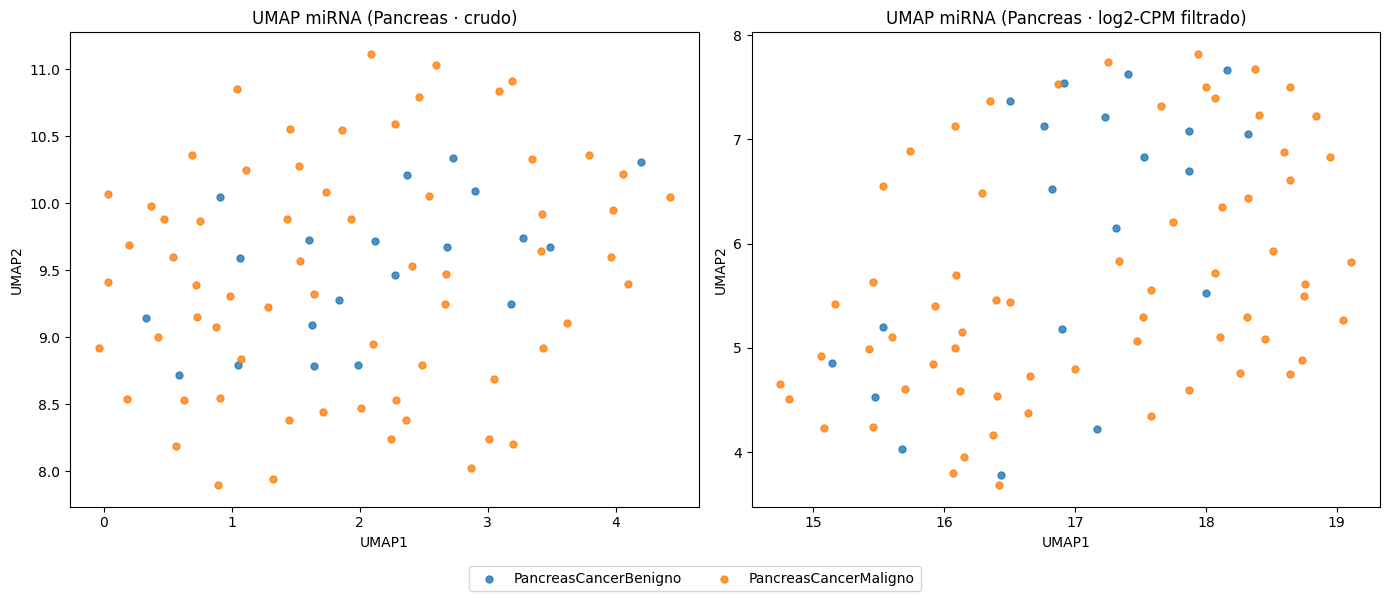

In [ ]:
# =============================================================
# Comparativa UMAP: crudo vs filtrado + normalizado (Pancreas)
# =============================================================

# UMAP con datos crudos
X_pancreas_raw = expr_pancreas.copy().T

scaler_raw = StandardScaler(with_mean=True, with_std=True)
X_pancreas_raw_scaled = scaler_raw.fit_transform(X_pancreas_raw)

labels_pancreas = meta_pancreas_min.set_index("sample_id")["label"].reindex(X_pancreas_raw.index).fillna("Unknown")

umap_raw = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric="euclidean")
X_pancreas_raw_umap = umap_raw.fit_transform(X_pancreas_raw_scaled)

umap_df_raw = pd.DataFrame(X_pancreas_raw_umap, columns=["UMAP1", "UMAP2"], index=X_pancreas_raw.index)
umap_df_raw["label"] = labels_pancreas.values

# UMAP con datos filtrados + normalizados
X_pancreas_norm = X_logcpm_samples_by_features_pancreas.copy()

scaler_norm = StandardScaler(with_mean=True, with_std=True)
X_pancreas_norm_scaled = scaler_norm.fit_transform(X_pancreas_norm)

labels_pancreas_norm = meta_pancreas_min.set_index("sample_id")["label"].reindex(X_pancreas_norm.index).fillna("Unknown")

umap_norm = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric="euclidean")
X_pancreas_norm_umap = umap_norm.fit_transform(X_pancreas_norm_scaled)

umap_df_norm = pd.DataFrame(X_pancreas_norm_umap, columns=["UMAP1", "UMAP2"], index=X_pancreas_norm.index)
umap_df_norm["label"] = labels_pancreas_norm.values

# Gráficos comparativos
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# UMAP crudo
for lab, sub in umap_df_raw.groupby("label"):
    axes[0].scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, label=lab, s=25)
axes[0].set_title("UMAP miRNA (Pancreas · crudo)")
axes[0].set_xlabel("UMAP1"); axes[0].set_ylabel("UMAP2")

# UMAP normalizado
for lab, sub in umap_df_norm.groupby("label"):
    axes[1].scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, label=lab, s=25)
axes[1].set_title("UMAP miRNA (Pancreas · log2-CPM filtrado)")
axes[1].set_xlabel("UMAP1"); axes[1].set_ylabel("UMAP2")

# Leyenda compartida
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), frameon=True)

plt.tight_layout(rect=[0,0.05,1,1])
plt.show()


# **Selección de características**

---
**Selección de características.**

---
En cada dataset (páncreas, mama y renal) voy a aplicar la selección de características después del filtrado de baja abundancia y la normalización (log2-CPM).

Este orden reduce ruido técnico, estabilizando la varianza y hace comparables las muestras, de modo que los métodos univariados y multivariados prioricen señal biológica real (diferencias entre clases) y no artefactos.

La selección se realiza por dataset, y más adelante se repetirá/ajustará en el análisis conjunto para controlar efectos de origen entre estudios.

#### **Análisis previo del dataset**

Tamaño del dataset (filtrado y normalizado): (85, 230)
Distribución de clases:
 label
PancreasCancerMaligno    65
PancreasCancerBenigno    20
Name: count, dtype: int64


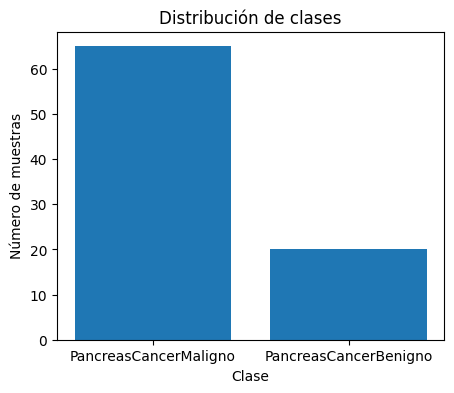

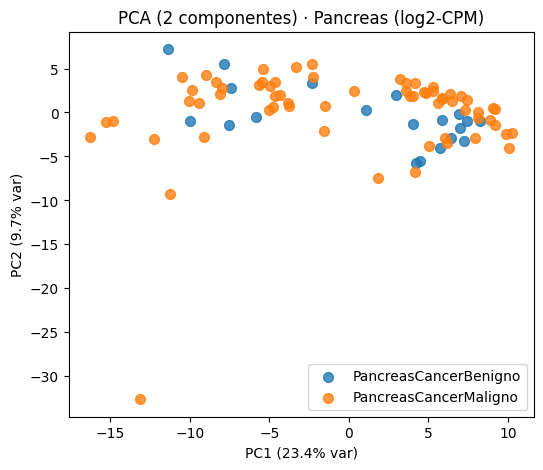

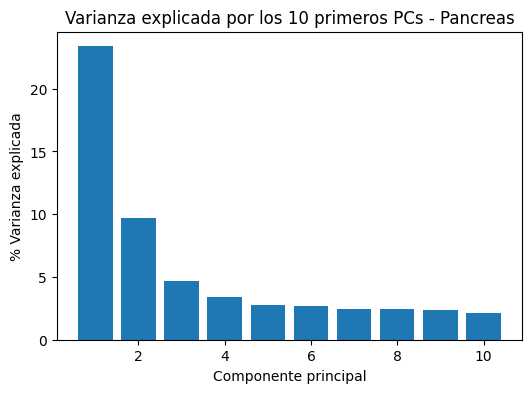

In [ ]:
# ==========================================================
# Matriz ya filtrada y normalizada (muestras x miRNA)
# ==========================================================
X_pancreas_norm = X_logcpm_samples_by_features_pancreas.copy()

# Selecciono las clases de interés: PancreasCancerMaligno y PancreasCancerBenigno
labels_pancreas = (
    meta_pancreas_min
    .set_index("sample_id")
    .loc[:, "label"]
    .reindex(X_pancreas_norm.index)
)

clases_interes = ["PancreasCancerBenigno", "PancreasCancerMaligno"]
mask = labels_pancreas.isin(clases_interes)

X = X_pancreas_norm.loc[mask].copy()
y = labels_pancreas.loc[mask]

print("Tamaño del dataset (filtrado y normalizado):", X.shape)
print("Distribución de clases:\n", y.value_counts())

# Estandarización (z-score por miRNA)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X.values)

# PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca = pca2.fit_transform(X_scaled)

# Distribución de clases
counts = y.value_counts()
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribución de clases")
plt.xlabel("Clase"); plt.ylabel("Número de muestras")
plt.show()

# PCA coloreado por clase
plt.figure(figsize=(6,5))
for cls in clases_interes:
    idx = (y == cls).values
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=cls, s=50, alpha=0.8)
plt.legend(); plt.title("PCA (2 componentes) · Pancreas (log2-CPM)")
plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}% var)")
plt.show()

# Varianza explicada (10 PCs)
pca10 = PCA(n_components=10, random_state=42).fit(X_scaled)
plt.figure(figsize=(6,4))
plt.bar(range(1,11), pca10.explained_variance_ratio_*100)
plt.xlabel("Componente principal"); plt.ylabel("% Varianza explicada")
plt.title("Varianza explicada por los 10 primeros PCs - Pancreas")
plt.show()


### **Métodos estadísticos**

#### **ANOVA F-test**

Voy a utilizar el **test ANOVA F** para evaluar si existen diferencias significativas en las medias de expresión de cada miARN entre las dos clases estudiandas (PancreasMaligno y PancreasBenigno).


Muestras y clases usadas:
label
Maligno    65
Benigno    20
Name: count, dtype: int64


,Feature,F_score,p_value,q_value_BH
0,miR-378a-3p,9.958521,0.002231,0.234543
1,miR-423-5p,9.451580,0.002855,0.234543
2,miR-574-3p,9.310479,0.003059,0.234543
3,miR-454-3p,8.143558,0.005455,0.313654
4,miR-143-3p,7.557170,0.007333,0.337313
5,miR-199b-5p,6.686675,0.011460,0.439289
6,miR-223-3p,5.909523,0.017213,0.553583
7,miR-185-5p,5.698200,0.019255,0.553583
8,miR-122-5p,5.354447,0.023142,0.562796
9,miR-34a-5p,5.250879,0.024469,0.562796


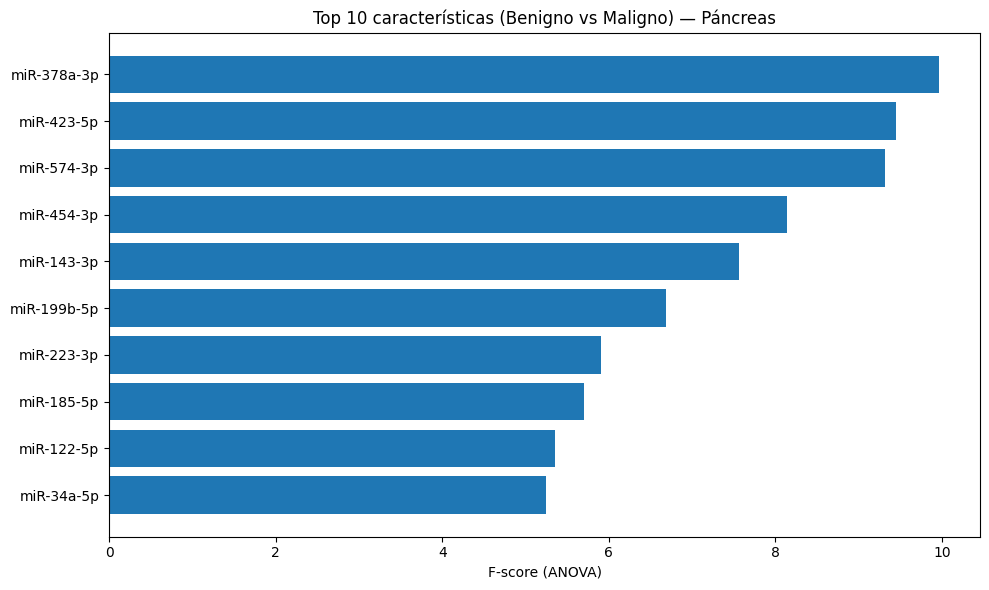


Guardado en variables: `anova_pancreas_df` (tabla completa) y `topN_pancreas_anova` (Top 10 features).


In [ ]:
# ==========================================================
# ANOVA (f_classif) para Pancreas: Benigno vs Maligno
# ==========================================================
# Uso de matriz normalizada: (muestras x miRNA)
X_pancreas_norm = X_logcpm_samples_by_features_pancreas.copy()

labels = (
    meta_pancreas_min
    .set_index("sample_id")
    .loc[:, "label"]
    .reindex(X_pancreas_norm.index)
)

clases_interes = ["PancreasCancerBenigno", "PancreasCancerMaligno"]
mask = labels.isin(clases_interes)

X = X_pancreas_norm.loc[mask].copy()
y = (
    labels.loc[mask]
    .map({"PancreasCancerBenigno": 0, "PancreasCancerMaligno": 1})
    .astype(int)
)

print("Muestras y clases usadas:")
print(y.replace({0:"Benigno", 1:"Maligno"}).value_counts())

# Limpio las columnas problemáticas si las hay (constantes o con NaNs) --> No hay
varianza = X.var(axis=0, ddof=1)
cols_const = varianza.index[varianza == 0]
if len(cols_const) > 0:
    X.drop(columns=cols_const, inplace=True)

if X.isna().any().any():
    X = X.fillna(X.median())

# ANOVA
selector = SelectKBest(score_func=f_classif, k="all")
_ = selector.fit_transform(X, y)

anova_results = pd.DataFrame({
    "Feature": X.columns.astype(str),
    "F_score": selector.scores_,
    "p_value": selector.pvalues_
}).sort_values(["F_score", "p_value"], ascending=[False, True]).reset_index(drop=True)

# Ajuste por múltiples comparaciones (Benjamini-Hochberg FDR)
def bh_fdr(pvals: pd.Series) -> pd.Series:
    p = pvals.values.astype(float)
    n = len(p)
    order = np.argsort(p)
    ranked = np.empty(n, dtype=float)
    cummin = 1.0
    for i in range(n-1, -1, -1):
        rank = i + 1
        val = p[order[i]] * n / rank
        cummin = min(cummin, val)
        ranked[order[i]] = min(cummin, 1.0)
    return pd.Series(ranked, index=pvals.index)

anova_results["q_value_BH"] = bh_fdr(anova_results["p_value"])

# Resultados principales
display(anova_results.head(10))

# Gráfico Top-N por F-score
topN = 10
top_df = anova_results.head(topN).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top_df["Feature"], top_df["F_score"])
plt.xlabel("F-score (ANOVA)")
plt.title(f"Top {topN} características (Benigno vs Maligno) — Páncreas")
plt.tight_layout()
plt.show()

# Variables para unir la información luego
anova_pancreas_df = anova_results.copy()
topN_pancreas_anova = anova_results.head(topN)["Feature"].tolist()

print(f"\nGuardado en variables: `anova_pancreas_df` (tabla completa) y `topN_pancreas_anova` (Top {topN} features).")

#### **Kruskal-Wallis (no paramétrico)**

Voy a utilziar el test de Kruskal–Wallis como alternativa no paramétrica a ANOVA. Comparando las distribuciones de cada miARN entre varios grupos usando rangos, sin asumir normalidad ni varianzas iguales.

In [ ]:
# =====================================================================
# Kruskal–Wallis por característica (Pancreas · log2-CPM, sin ComBat)
# =====================================================================

# X normalizado (muestras x miRNA)
X_pancreas_norm = X_logcpm_samples_by_features_pancreas.copy()

labels_pancreas = (
    meta_pancreas_min
    .set_index("sample_id")["label"]
    .reindex(X_pancreas_norm.index)
)

clases_interes = ["PancreasCancerBenigno", "PancreasCancerMaligno"]
mask = labels_pancreas.isin(clases_interes)

X = X_pancreas_norm.loc[mask].copy()
y = labels_pancreas.loc[mask].copy()

# Quito las columnas cconstantes y relleno NaNs (si hay) con la mediana --> No hay
Xk = X.copy()
varianza = Xk.var(axis=0, ddof=1)
const_cols = varianza.index[varianza == 0]
if len(const_cols) > 0:
    Xk.drop(columns=const_cols, inplace=True)

if Xk.isna().any().any():
    Xk = Xk.fillna(Xk.median())

y_ser = pd.Series(y, index=Xk.index)

def kruskal_safe(Xd: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    rows = []
    classes = pd.unique(y)
    for col in Xd.columns:
        groups = [Xd.loc[y == c, col].values for c in classes]
        try:
            H, p = stats.kruskal(*groups)
        except ValueError:
            H, p = 0.0, 1.0
        rows.append((col, H, p))
    out = pd.DataFrame(rows, columns=["miRNA", "H", "p"]).sort_values("p", ascending=True)
    # Corrección por múltiples comparaciones (Benjamini–Hochberg)
    out["p_adj_bh"] = multipletests(out["p"], method="fdr_bh")[1]
    return out

# Escala de entrada ya es log2-CPM
kruskal_df = kruskal_safe(Xk, y_ser)
display(kruskal_df.head(10))

# Guardo los resultados para usos posteriores
kruskal_pancreas_df = kruskal_df.copy()
top20_pancreas_kruskal = kruskal_df.nsmallest(20, "p")["miRNA"].tolist()

print(f"Columnas constantes eliminadas: {len(const_cols)}")
print("Variables guardadas: `kruskal_pancreas_df` (tabla completa) y `top20_pancreas_kruskal` (lista).")


,miRNA,H,p,p_adj_bh
17,miR-423-5p,9.026834,0.002660,0.345469
78,miR-140-3p,8.626802,0.003313,0.345469
126,miR-378a-3p,8.067707,0.004506,0.345469
115,miR-107,7.049430,0.007929,0.455920
51,miR-143-3p,6.390268,0.011475,0.494585
36,miR-185-5p,6.182469,0.012902,0.494585
179,miR-34a-5p,5.808960,0.015945,0.523898
201,miR-199b-5p,5.362883,0.020570,0.579929
150,miR-877-5p,5.191865,0.022693,0.579929
55,miR-122-5p,4.915492,0.026617,0.612188


Columnas constantes eliminadas: 0
Variables guardadas: `kruskal_pancreas_df` (tabla completa) y `top20_pancreas_kruskal` (lista).


#### **Mutual Information (dependencia no lineal)**

Utilizo **Mutual Information (MI)** para medir la dependencia (lineal o no lineal) entre la expresión de cada miARN y la variable de clase. A diferencia de ANOVA o Kruskal, MI no devuelve un p-valor, sino un valor de información (≥0), donde los valores altos indican mayor poder de discriminación.

In [ ]:
# ===================================================================================
# Mutual Information (MI) para selección de características · Pancreas (log2-CPM)
# ===================================================================================

# Para mayor estabilidad, he subido los vecinos a 5 (antes he probado con 3)
mi_vals = mutual_info_classif(
    Xk,                           # matriz muestras x miRNA (sin constantes, NaNs tratados)
    y_ser,                        # etiquetas ("PancreasCancerBenigno"/"PancreasCancerMaligno")
    random_state=42,
    discrete_features=False,
    n_neighbors=5
)

mi_df = pd.DataFrame({
    "miRNA": Xk.columns,
    "MI": mi_vals
}).sort_values("MI", ascending=False).reset_index(drop=True)

display(mi_df.head(10))

# Guardo para reutilizar
mi_pancreas_df = mi_df.copy()
top20_pancreas_mi = mi_df.head(20)["miRNA"].tolist()

print("Variables guardadas: `mi_pancreas_df` (tabla completa) y `top20_pancreas_mi` (lista).")


,miRNA,MI
0,miR-107,0.123071
1,miR-495-3p,0.096097
2,miR-22-3p,0.091948
3,miR-22-5p,0.087696
4,miR-379-5p,0.087496
5,miR-409-3p,0.087018
6,miR-20a-3p,0.085968
7,miR-200c-3p,0.074552
8,miR-20b-5p,0.072111
9,miR-574-5p,0.072072


Variables guardadas: `mi_pancreas_df` (tabla completa) y `top20_pancreas_mi` (lista).


#### **Panel candidato de miRNAs no redundantes para páncreas (consenso ANOVA/Kruskal/MI + poda por correlación)**

---

El objetivo es **integrar los resultados de varios métodos de selección** (ANOVA, Kruskal–Wallis y Mutual Information) para priorizar miRNAs relevantes y, a continuación, eliminar redundancia entre ellos mediante una **poda por alta correlación**.
De esta manera obtengo un panel compacto y no redundante que mejora la interpretabilidad, reduce multicolineidad, disminuye el riesgo de sobreajuste y **manteniendo la señal biológica clave para distinguir benigno vs maligno**.


In [ ]:
# =============================================================================
# Panel no redundante + Summary (con semilla por Borda y poda greedy estable)
# =============================================================================

# ---------------------------------------------- Este código no sería necesario (pero así lo ejecuto sin lo anterior) ---------------------------------------------------------------------
# Helpers de normalización
def norm_anova(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('feature') or cols.get('mirna') or 'miRNA'
    F_col     = cols.get('f_score') or cols.get('f')
    p_col     = cols.get('p_value') or cols.get('p')
    q_col     = cols.get('q_value_bh') or cols.get('p_adj_bh')

    out = pd.DataFrame()
    out['miRNA']    = df[mirna_col].astype(str) if (mirna_col in df.columns) else pd.Series(dtype=str)
    out['F']        = df[F_col] if (F_col in df.columns) else np.nan
    out['p']        = df[p_col] if (p_col in df.columns) else np.nan
    out['p_adj_bh'] = df[q_col] if (q_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','F','p','p_adj_bh']]

def norm_kruskal(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('mirna') or 'miRNA'
    H_col     = cols.get('h') or 'H'
    p_col     = cols.get('p') or cols.get('p_value') or 'p'
    q_col     = cols.get('p_adj_bh') or cols.get('q_value_bh') or 'p_adj_bh'

    out = pd.DataFrame()
    out['miRNA']    = df[mirna_col].astype(str) if (mirna_col in df.columns) else pd.Series(dtype=str)
    out['H']        = df[H_col] if (H_col in df.columns) else np.nan
    out['p']        = df[p_col] if (p_col in df.columns) else np.nan
    out['p_adj_bh'] = df[q_col] if (q_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','H','p','p_adj_bh']]

def norm_mi(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('mirna') or 'miRNA'
    mi_col    = cols.get('mi') or 'MI'
    out = pd.DataFrame()
    out['miRNA'] = df[mirna_col].astype(str) if (mirna_col in df.columns) else pd.Series(dtype=str)
    out['MI']    = df[mi_col] if (mi_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','MI']]

anova_sources   = [globals().get('anova_pancreas_df'), globals().get('anova_df'), globals().get('anova_results')]
kruskal_sources = [globals().get('kruskal_pancreas_df'), globals().get('kruskal_df')]
mi_sources      = [globals().get('mi_pancreas_df'), globals().get('mi_df')]

anova_df = next((norm_anova(df)   for df in anova_sources   if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','F','p','p_adj_bh']))
kruskal_df = next((norm_kruskal(df) for df in kruskal_sources if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','H','p','p_adj_bh']))
mi_df = next((norm_mi(df)        for df in mi_sources      if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','MI']))
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Matriz de referencia para las correlaciones
if 'Xk' in globals() and isinstance(Xk, pd.DataFrame):
    Xf = Xk.copy()
else:
    Xf = X_logcpm_samples_by_features_pancreas.copy()
    labels_pancreas = (meta_pancreas_min.set_index("sample_id")["label"].reindex(Xf.index))
    mask_two = labels_pancreas.isin(["PancreasCancerBenigno","PancreasCancerMaligno"])
    if mask_two.notna().any():
        Xf = Xf.loc[mask_two.fillna(False)]

# Semilla estable: Uso borda_top si existe; si no, creo ranking ordenado sin sets
# (He comprobado que los resultados son exactamente los mismos, usando la semilla o el set)
def dedup_preserve_order(seq):
    return list(OrderedDict.fromkeys(seq))

if 'borda_top' in globals() and isinstance(borda_top, (list, tuple)) and len(borda_top) > 0:
    panel_seed = dedup_preserve_order(borda_top)
else:
    N = 50
    seed_parts = []
    if not anova_df.empty:
        colp = 'p_adj_bh' if anova_df['p_adj_bh'].notna().any() else 'p'
        seed_parts += list(anova_df.sort_values(colp, ascending=True)['miRNA'].dropna().astype(str).head(N))
    if not kruskal_df.empty:
        colpkw = 'p_adj_bh' if kruskal_df['p_adj_bh'].notna().any() else 'p'
        seed_parts += list(kruskal_df.sort_values(colpkw, ascending=True)['miRNA'].dropna().astype(str).head(N))
    if not mi_df.empty:
        seed_parts += list(mi_df.sort_values('MI', ascending=False)['miRNA'].dropna().astype(str).head(N))
    panel_seed = dedup_preserve_order([m for m in seed_parts if m in Xf.columns])
    if len(panel_seed) == 0:
        panel_seed = list(Xf.columns)

# Poda greedy por correlación (mejor-primero, = más estable)
def prune_by_correlation_greedy(Xd: pd.DataFrame, ordered_features, thr=0.90, method='pearson'):
    """
    Mantiene las features en el orden dado. Una nueva feature se acepta
    solo si su |corr| con TODAS las ya aceptadas es <= thr.
    method: 'pearson' (por defecto) o 'spearman'
    """
    feats = [f for f in ordered_features if f in Xd.columns]
    kept = []
    dropped = []
    if len(feats) <= 1:
        return feats, dropped

    sub = Xd[feats]
    if method == 'spearman':
        corr_mat = sub.rank(axis=0).corr(method='pearson').abs()
    else:
        corr_mat = sub.corr(method='pearson').abs()

    for f in feats:
        if not kept:
            kept.append(f)
            continue
        # si está altamente correlacionada con alguna ya aceptada la elimino
        if any(corr_mat.loc[f, k] > thr for k in kept if f != k):
            dropped.append(f)
        else:
            kept.append(f)
    return kept, dropped

# Parámetros visibles
PANEL_K    = 15           # tamaño objetivo del panel (este valor lo he sacado de hacer el RFECV salía 13, pero lo he generalizado a 15 para todos los datasets)
CORR_THR   = 0.90         # umbral de correlación (|r|)
CORR_METHOD = 'pearson'   # 'pearson' o 'spearman'

panel_keep, panel_drop = prune_by_correlation_greedy(Xf, panel_seed, thr=CORR_THR, method=CORR_METHOD)
panel_final = panel_keep[:PANEL_K]

print(f"Semilla inicial (n={len(panel_seed)}), método de correlación={CORR_METHOD}, thr={CORR_THR}")
print(f"Panel candidato (no redundante, k={len(panel_final)}): {panel_final}")
print(f"Descartadas por alta correlación (> {CORR_THR}): {len(panel_drop)}")

# Resumen unificado
summary = pd.DataFrame({"miRNA": panel_final})

# Añado ANOVA
if not anova_df.empty:
    summary = summary.merge(anova_df, on="miRNA", how="left")

# Añado Kruskal (renombro p y p_adj para no pisar las columnas)
if not kruskal_df.empty:
    summary = summary.merge(
        kruskal_df.rename(columns={"p": "p_kw", "p_adj_bh": "p_kw_adj"}),
        on="miRNA", how="left"
    )

# Añado MI
if not mi_df.empty:
    summary = summary.merge(mi_df, on="miRNA", how="left")

# Renombro p de ANOVA si existe
if 'p' in summary.columns:
    summary = summary.rename(columns={"p": "p_anova"})
if 'p_adj_bh' in summary.columns:
    summary = summary.rename(columns={"p_adj_bh": "p_anova_adj"})

# Orden estable: p-values ascendentes y MI descendente, según existan
sort_cols = [c for c in ["p_anova_adj","p_anova","p_kw_adj","p_kw","MI"] if c in summary.columns]
ascending_flags = []
for c in sort_cols:
    ascending_flags.append(False if c == "MI" else True)

summary_sorted = summary.sort_values(sort_cols, ascending=ascending_flags).reset_index(drop=True)

display(summary_sorted)


Semilla inicial (n=93), método de correlación=pearson, thr=0.9
Panel candidato (no redundante, k=15): ['miR-378a-3p', 'miR-423-5p', 'miR-574-3p', 'miR-454-3p', 'miR-143-3p', 'miR-199b-5p', 'miR-223-3p', 'miR-185-5p', 'miR-122-5p', 'miR-34a-5p', 'miR-1290', 'miR-539-3p', 'miR-362-3p', 'miR-361-3p', 'miR-140-3p']
Descartadas por alta correlación (> 0.9): 0


,miRNA,F,p_anova,p_anova_adj,H,p_kw,p_kw_adj,MI
0,miR-378a-3p,9.958521,0.002231,0.234543,8.067707,0.004506,0.345469,0.009075
1,miR-423-5p,9.451580,0.002855,0.234543,9.026834,0.002660,0.345469,0.036666
2,miR-574-3p,9.310479,0.003059,0.234543,3.249660,0.071438,0.678661,0.040198
3,miR-454-3p,8.143558,0.005455,0.313654,4.250596,0.039237,0.661005,0.022504
4,miR-143-3p,7.557170,0.007333,0.337313,6.390268,0.011475,0.494585,0.049366
5,miR-199b-5p,6.686675,0.011460,0.439289,5.362883,0.020570,0.579929,0.022459
6,miR-223-3p,5.909523,0.017213,0.553583,4.293381,0.038261,0.661005,0.004393
7,miR-185-5p,5.698200,0.019255,0.553583,6.182469,0.012902,0.494585,0.054226
8,miR-122-5p,5.354447,0.023142,0.562796,4.915492,0.026617,0.612188,0.018309
9,miR-34a-5p,5.250879,0.024469,0.562796,5.808960,0.015945,0.523898,0.032528


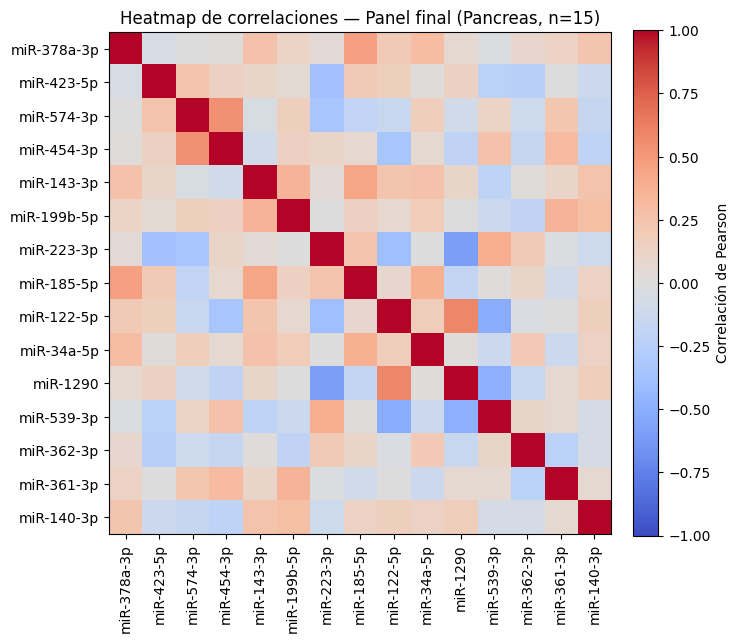

In [ ]:
# ===========================================
# Heatmap de correlaciones — Panel final
# ===========================================

# Selección de la matriz base para correlaciones
if 'Xf' in globals() and isinstance(Xf, pd.DataFrame):
    # Si existe cojo la misma que uso para la poda por correlación
    X_corr_base = Xf.copy()
elif 'X_in' in globals() and isinstance(X_in, pd.DataFrame):
    X_corr_base = X_in.copy()
else:
    # Si no existe utilizo la matriz log2-CPM de páncreas (muestras x miRNA), limitada a Benigno/Maligno
    X_corr_base = X_logcpm_samples_by_features_pancreas.copy()
    labels_pancreas = (
        meta_pancreas_min
        .set_index("sample_id")["label"]
        .reindex(X_corr_base.index)
    )
    mask_two = labels_pancreas.isin(["PancreasCancerBenigno","PancreasCancerMaligno"])
    X_corr_base = X_corr_base.loc[mask_two.fillna(False)]

# Filtrado a las features del panel que existan en la matriz
features_hm = [f for f in panel_final if f in X_corr_base.columns]

if len(features_hm) < 2:
    print("No hay suficientes características en panel_final para un heatmap de correlación (se requieren ≥2).")
else:
    # Matriz de correlación (Pearson)
    corr = X_corr_base[features_hm].corr(method='pearson')

    # Heatmap
    plt.figure(figsize=(max(6, 0.5*len(features_hm)), max(5, 0.5*len(features_hm))))
    im = plt.imshow(corr.values, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar(im, fraction=0.046, pad=0.04, label='Correlación de Pearson')

    plt.xticks(ticks=np.arange(len(features_hm)), labels=features_hm, rotation=90)
    plt.yticks(ticks=np.arange(len(features_hm)), labels=features_hm)
    plt.title(f"Heatmap de correlaciones — Panel final (Pancreas, n={len(features_hm)})")
    plt.tight_layout()
    plt.show()


#### **Log2FC y tamaño de efecto (Cohen´s d) en One-vs-all**

Mientras que **ANOVA, Kruskal o MI** indican si hay **diferencias globales entre grupos**, no muestran qué grupo concreto está impulsando esas diferencias ni la magnitud de los cambios.

Por ello, voy a calcular el **log2 Fold Change (log2FC)** y el **tamaño de efecto (Cohen´s d)** en un **esquema one-vs-all**, haciendo una comparación entre las dos clases y permitiendo identificar miARNs sobreexpresados o infraexpresados en un grupo concreto.

##### **Log2FC one-vs-all**

De 15 miARNs en panel_final, 15 están en la matriz base.


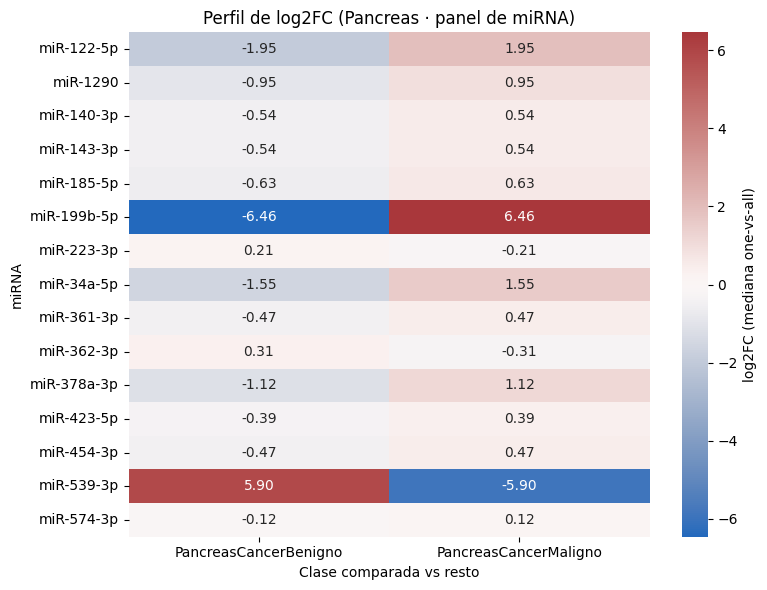

In [ ]:
# =================================================
# Efectos de tamaño (log2FC y Cohen's d) + Heatmap
# =================================================

def effect_table(X_df, y_series, miRNAs=None):
    if miRNAs is None:
        miRNAs = X_df.columns
    classes = pd.unique(y_series)
    rows = []
    for m in miRNAs:
        for c in classes:
            g1 = X_df.loc[y_series==c, m].values
            g0 = X_df.loc[y_series!=c, m].values
            log2fc = np.median(g1) - np.median(g0)
            s1, s0 = np.std(g1, ddof=1), np.std(g0, ddof=1)
            n1, n0 = len(g1), len(g0)
            sp = np.sqrt(((n1-1)*s1**2 + (n0-1)*s0**2) / (n1+n0-2)) if (n1+n0-2)>0 else np.nan
            d = (np.mean(g1) - np.mean(g0)) / sp if sp>0 else np.nan
            rows.append((m, c, log2fc, d, n1, n0))
    return pd.DataFrame(rows, columns=["miRNA","class","log2FC_median","cohens_d","n_class","n_other"])

# Matriz base
if 'Xf' in globals() and isinstance(Xf, pd.DataFrame):
    X_base = Xf.copy()
else:
    X_base = X_logcpm_samples_by_features_pancreas.copy()
    labels_pancreas = meta_pancreas_min.set_index("sample_id")["label"].reindex(X_base.index)
    mask_two = labels_pancreas.isin(["PancreasCancerBenigno","PancreasCancerMaligno"])
    X_base = X_base.loc[mask_two.fillna(False)]
    y_ser = labels_pancreas.loc[X_base.index]

# Panel existente y alineado
panel = [m for m in panel_final if m in X_base.columns]
print(f"De {len(panel_final)} miARNs en panel_final, {len(panel)} están en la matriz base.")
y_ser = y_ser.reindex(X_base.index)

res_effects = effect_table(X_base, y_ser, miRNAs=panel)

# Heatmap:
heat_df = res_effects.pivot(index="miRNA", columns="class", values="log2FC_median")

plt.figure(figsize=(8, max(6, 0.4*len(panel))))
sns.heatmap(heat_df, cmap="vlag", center=0, annot=True, fmt=".2f",
            cbar_kws={"label":"log2FC (mediana one-vs-all)"})
plt.title("Perfil de log2FC (Pancreas · panel de miRNA)")
plt.ylabel("miRNA"); plt.xlabel("Clase comparada vs resto")
plt.tight_layout(); plt.show()


##### **Cohen's d one-vs-all**

El **log2FC** indica la **dirección y magnitud cruda de la diferencia**, pero puede verse afectado por la escala de los datos. No obstante, el **Cohen’s d**, mide la **diferencia estandarizada** (diferencia de medias / desviación combinada).

- d ≈ 0.2 → efecto pequeño
- d ≈ 0.5 → efecto moderado
- d ≥ 0.8 → efecto grande

Esto lo hace más comparable y útil para priorizar biomarcadores.

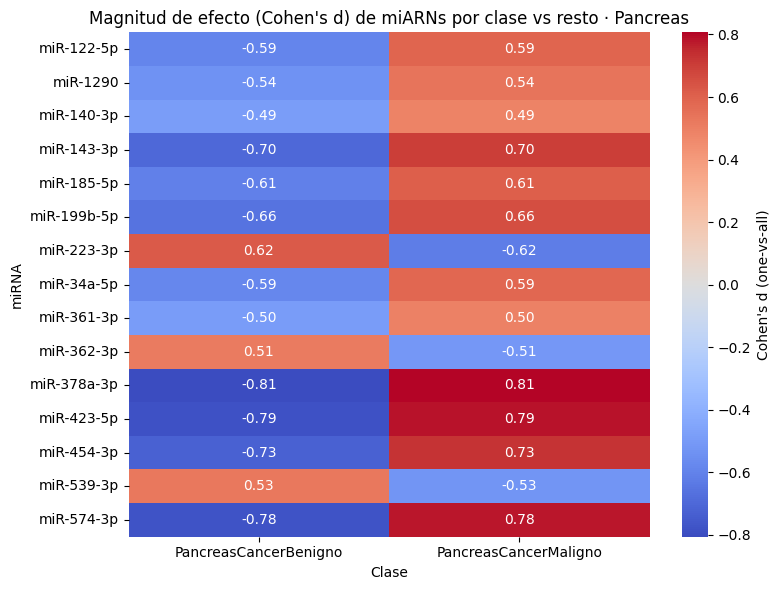

In [ ]:
# ============================================
# Heatmap de tamaños de efecto (Cohen's d)
# ============================================

# Uso la misma matriz base que en el panel (log2-CPM, muestras x miRNA)
if 'Xf' in globals() and isinstance(Xf, pd.DataFrame):
    X_base = Xf.copy()
else:
    X_base = X_logcpm_samples_by_features_pancreas.copy()
    labels_pancreas = (
        meta_pancreas_min
        .set_index("sample_id")["label"]
        .reindex(X_base.index)
    )
    mask_two = labels_pancreas.isin(["PancreasCancerBenigno","PancreasCancerMaligno"])
    X_base = X_base.loc[mask_two.fillna(False)]
    y_ser = labels_pancreas.loc[X_base.index]

y_ser = y_ser.reindex(X_base.index)

# Filtrado de panel a columnas existentes
panel = [m for m in panel_final if m in X_base.columns]
if len(panel) == 0:
    print("No hay miRNAs del panel en la matriz base.")
else:
    # Reutilizo la función effect_table (log2FC y Cohen's d)
    res_effects = effect_table(X_base, y_ser, miRNAs=panel)

    # Matriz Cohen's d (miRNA x clase)
    heat_d = res_effects.pivot(index="miRNA", columns="class", values="cohens_d")

    # Heatmap
    plt.figure(figsize=(8, max(6, 0.4*len(panel))))
    sns.heatmap(heat_d, cmap="coolwarm", center=0, annot=True, fmt=".2f",
                cbar_kws={"label":"Cohen's d (one-vs-all)"})
    plt.title("Magnitud de efecto (Cohen's d) de miARNs por clase vs resto · Pancreas")
    plt.ylabel("miRNA"); plt.xlabel("Clase")
    plt.tight_layout()
    plt.show()


### **Métodos embebidos**

#### **Logistic Regression con regularización**

La **regresión logística multinomial** es un modelo lineal que predice la probabilidad de pertenencia a cada clase.

Cuando se usa la **regularización L1 (LASSO) o Elastic Net**, se añade una penalización a los coeficientes:

- **L1 (LASSO)**: fuerza muchos coeficientes a cero y selecciona directamente un subconjunto de variables.

- **Elastic Net**: combina L1 y L2, lo cual lo hace más estable cuando hay correlación moderada entre las features.

**Objetivos:**
- Evaluar la capacidad predictiva del panel de miARNs.
- Identificar cuáles son los miARNs con coeficientes diferentes a 0 (seleccionados por el modelo).
- Ver qué miARNs tienen más peso para clasificar las clases (PancreasBenigno y PancreasMaligno).

**Ventaja:**
En parte es interpretable, es decir, podemos leer los coeficientes para cada miARN. Eso sí, hay que tener cuidado ya que los coeficientes pueden variar según la normalización y el solapamiento de señales.

In [ ]:
# =============================================================
# Embedded feature selection · Logistic Regression (Pancreas)
# =============================================================

X_base = Xf.copy()                                  # muestras x features (log2-CPM, 2 clases)
y_base = pd.Series(y_ser).reindex(X_base.index)

features_panel = [f for f in panel_final if f in X_base.columns]
if len(features_panel) == 0:
    raise RuntimeError("Ninguna feature del panel_final está en Xf.")
X_emb = X_base[features_panel].copy()
if X_emb.isna().any().any():
    X_emb = X_emb.fillna(X_emb.median())

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Devuelve los coeficientes por feature (cols = clases si k>1; si es binario, una sola col para la clase positiva).
def coef_df(clf, feature_names):
    coef = clf.coef_                         # (k, p) o (1, p)
    classes = clf.classes_
    if coef.shape[0] == 1:
        colnames = [str(classes[1]) if len(classes) >= 2 else "class1"]
    else:
        colnames = [str(c) for c in classes]
    df = pd.DataFrame(coef.T, index=feature_names, columns=colnames)
    df["coef_abs_mean"] = df.abs().mean(axis=1)
    return df.sort_values("coef_abs_mean", ascending=False)

def mean_cv_auc(clf):
    return float(np.mean([v.mean() for v in clf.scores_.values()]))

# ======================
# Baseline L2 (estable)
# =====================
pipe_l2 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        cv=cv,
        scoring="roc_auc",
        max_iter=8000,
        n_jobs=None,
        refit=True,
        random_state=42
    ))
])

pipe_l2.fit(X_emb, y_base)
clf_l2 = pipe_l2.named_steps["clf"]
coefs_l2_sorted = coef_df(clf_l2, features_panel)
auc_l2 = mean_cv_auc(clf_l2)

print("=== L2 (baseline) · Top 15 por |coef| medio ===")
display(coefs_l2_sorted.head(15))
print(f"AUC-CV (media): {mean_cv_auc(clf_l2):.3f}")

# =================================
# L1 (sparse) para selección real
# =================================
pipe_l1 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),      # En ese caso no he tenido que ampliar a np.logspace(-4,4,25) --> Pq no son todo ceros
        penalty="l1",
        solver="liblinear",             # L1 binario
        class_weight="balanced",
        cv=cv,
        scoring="roc_auc",
        max_iter=8000,
        n_jobs=None,
        refit=True,
        random_state=42
    ))
])

pipe_l1.fit(X_emb, y_base)
clf_l1 = pipe_l1.named_steps["clf"]
coefs_l1_sorted = coef_df(clf_l1, features_panel)

# Me quedo con los coef diferentes a 0 en alguna clase
selected_l1 = coefs_l1_sorted.drop(columns=["coef_abs_mean"]).abs().sum(axis=1)
selected_l1 = selected_l1[selected_l1 > 0].index.tolist()
auc_l1 = mean_cv_auc(clf_l1)

print("\n=== L1 (sparse) · Selección real ===")
print(f"Features con coeficiente ≠ 0: {len(selected_l1)}")
display(coefs_l1_sorted.loc[selected_l1].head(15))
print(f"AUC-CV (media): {mean_cv_auc(clf_l1):.3f}")

# =============================================
# Elastic Net (SAGA) – mezcla suave de L1 y L2
# =============================================
pipe_en = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),
        penalty="elasticnet",
        solver="saga",
        l1_ratios=[0.1, 0.3, 0.5],      # Los he puesto suaves para evitar "todo 0"
        class_weight="balanced",
        cv=cv,
        scoring="roc_auc",
        max_iter=10000,
        n_jobs=None,
        refit=True,
        random_state=42
    ))
])

pipe_en.fit(X_emb, y_base)
clf_en = pipe_en.named_steps["clf"]
coefs_en_sorted = coef_df(clf_en, features_panel)

selected_en = coefs_en_sorted.drop(columns=["coef_abs_mean"]).abs().sum(axis=1)
selected_en = selected_en[selected_en > 0].index.tolist()
auc_en = mean_cv_auc(clf_en)

print("\n=== Elastic Net (saga) ===")
print(f"Features con coeficiente ≠ 0: {len(selected_en)}")
display(coefs_en_sorted.loc[selected_en].head(15))
print(f"AUC-CV (media): {mean_cv_auc(clf_en):.3f}")


=== L2 (baseline) · Top 15 por |coef| medio ===


,PancreasCancerMaligno,coef_abs_mean
miR-378a-3p,0.039135,0.039135
miR-423-5p,0.036852,0.036852
miR-574-3p,0.036592,0.036592
miR-454-3p,0.035525,0.035525
miR-143-3p,0.033269,0.033269
miR-199b-5p,0.031295,0.031295
miR-185-5p,0.030323,0.030323
miR-223-3p,-0.029610,0.029610
miR-34a-5p,0.028483,0.028483
miR-122-5p,0.028352,0.028352


AUC-CV (media): 0.841


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== L1 (sparse) · Selección real ===
Features con coeficiente ≠ 0: 13


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,PancreasCancerMaligno,coef_abs_mean
miR-454-3p,1.673080,1.673080
miR-423-5p,0.718929,0.718929
miR-223-3p,-0.713426,0.713426
miR-378a-3p,0.672304,0.672304
miR-140-3p,0.647718,0.647718
miR-539-3p,-0.641092,0.641092
miR-574-3p,0.362327,0.362327
miR-143-3p,0.362077,0.362077
miR-1290,0.215393,0.215393
miR-122-5p,0.199659,0.199659


AUC-CV (media): 0.696

=== Elastic Net (saga) ===
Features con coeficiente ≠ 0: 15


,PancreasCancerMaligno,coef_abs_mean
miR-454-3p,0.493424,0.493424
miR-378a-3p,0.425635,0.425635
miR-423-5p,0.342728,0.342728
miR-574-3p,0.327078,0.327078
miR-140-3p,0.325673,0.325673
miR-539-3p,-0.301609,0.301609
miR-185-5p,0.296423,0.296423
miR-223-3p,-0.293509,0.293509
miR-362-3p,-0.250640,0.250640
miR-143-3p,0.224718,0.224718


AUC-CV (media): 0.734


In [ ]:
# Tabla resumen de los resultados de las tres regulaciones
tabla = pd.DataFrame({
    "Método": ["L2 (Ridge)", "L1 (Lasso)", "Elastic Net"],
    "Nº features": [
        len(features_panel),
        len(selected_l1),
        len(selected_en)
    ],
    "AUC-CV (media)": [auc_l2, auc_l1, auc_en],
    "Top 5 miARNs": [
        ", ".join(coefs_l2_sorted.head(5).index),
        ", ".join(coefs_l1_sorted.loc[selected_l1].head(5).index),
        ", ".join(coefs_en_sorted.loc[selected_en].head(5).index),
    ]
})

display(tabla)

,Método,Nº features,AUC-CV (media),Top 5 miARNs
0,L2 (Ridge),15,0.840769,"miR-378a-3p, miR-423-5p, miR-574-3p, miR-454-3..."
1,L1 (Lasso),13,0.695897,"miR-454-3p, miR-423-5p, miR-223-3p, miR-378a-3..."
2,Elastic Net,15,0.734103,"miR-454-3p, miR-378a-3p, miR-423-5p, miR-574-3..."


---
**Posible texto para la memoria**

---
Se han utilizado modelos lineales penalizados **(logistic regression con regularización)** para discriminar entre clases de un mismo dataset. En este caso el objetivo se centra más en seleccionar las *features* (miARNs) más relevantes biológicamente), antes que en la predicción de clases.

Para ello, he trabajado con las siguientes regularizaciones como mecanismos de selección:
  - **L2 (Ridge)**: no hace feature selection, pero estabiliza los coeficientes y da un ranking fiable de importancia.

  - **L1 (Lasso)**: fuerza a que muchos coeficientes sean exactamente cero, lo que resulta en una selección real de variables.

  - **Elastic Net**: combina L1 y L2, útil para datasets con correlación alta entre variables (como en este caso, miARNs). Permite selección más estable que L1 puro.

También hay que mencionar, que se ha realizado **validación cruzada estratificada** (5-fold CV con *roc_auc* como métrica), con el objetivo de reflejar en menor medida de los resultados el desbalanceo latente en las clases.

#### **Random Forest para selección de características**

Random Forest (RF) es un ensamble de árboles de decisión que:
- Evalúa muchas particiones de los datos.
- Puede manejar relaciones no lineales y complejas.
- Es robusto al ruido y a variables correlacionadas.

En este contexto lo uso para dos cosas:
- Evaluar la capacidad predictiva del panel de miARNs.
- Obtener importancias de variables (qué miARNs contribuyen más a la clasificación).

**Tipos de importancias:**
- **Importancia Gini (impureza)**: rápida, pero tiende a sobrevalorar variables con más categorías o varianza.
- **Permutation importance**: mide cuánto se degrada el rendimiento del modelo si permutamos aleatoriamente un miARN. Es más fiable, aunque más costosa computacionalmente.

En este apartado el **objetivo** es identificar los miARNs con mayor relevancia en el panel, tanto por Gini como por permutation.

In [ ]:
# =========================================================
# Random Forest · Pancreas (log2-CPM, features filtradas)
# =========================================================

X_rf = Xf.copy()
y_rf = pd.Series(y_ser).reindex(X_rf.index)

# CV estratificada con 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo RF (voy a usar "min_samples_leaf2" para evitar el overfitting)
rf_all = RandomForestClassifier(
    n_estimators=800,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1,
    max_features="sqrt",
    min_samples_leaf=2,
    oob_score=False
)

# Validación cruzada (F1 macro por desbalanceo)
scores_all = cross_val_score(rf_all, X_rf, y_rf, cv=cv, scoring="f1_macro", n_jobs=-1)
print(f"F1-macro CV ({X_rf.shape[1]} miRNA): {scores_all.mean():.3f} ± {scores_all.std():.3f}")

rf_all.fit(X_rf, y_rf)

# Importancias Gini
gini_all = pd.DataFrame({
    "miRNA": X_rf.columns,
    "importance_gini": rf_all.feature_importances_
}).sort_values("importance_gini", ascending=False)

print("Top 15 miRNA por Gini:")
display(gini_all.head(15))

# Importancias por permutación (misma métrica de CV)
perm_all = permutation_importance(
    rf_all, X_rf, y_rf,
    scoring="f1_macro",
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)
perm_imp_all = pd.DataFrame({
    "miRNA": X_rf.columns,
    "importance_perm": perm_all.importances_mean,
    "importance_perm_std": perm_all.importances_std
}).sort_values("importance_perm", ascending=False)

print("Top 15 miRNA por Permutation:")
display(perm_imp_all.head(15))



F1-macro CV (230 miRNA): 0.433 ± 0.000
Top 15 miRNA por Gini:


,miRNA,importance_gini
78,miR-140-3p,0.028552
17,miR-423-5p,0.019952
179,miR-34a-5p,0.017455
115,miR-107,0.015929
126,miR-378a-3p,0.015816
150,miR-877-5p,0.013335
84,miR-495-3p,0.013304
62,miR-454-3p,0.012803
16,miR-17-5p,0.012781
36,miR-185-5p,0.012498


Top 15 miRNA por Permutation:


,miRNA,importance_perm,importance_perm_std
0,miR-126-5p,0.0,0.0
1,miR-223-3p,0.0,0.0
2,miR-23a-3p,0.0,0.0
3,miR-150-5p,0.0,0.0
4,miR-191-5p,0.0,0.0
5,miR-25-3p,0.0,0.0
6,miR-146a-5p,0.0,0.0
7,miR-19a-3p,0.0,0.0
8,miR-126-3p,0.0,0.0
9,miR-451a,0.0,0.0


In [ ]:
# ===========================================================================
# Random Forest · Pancreas (log2-CPM) con Permutation OOF y comparativa
# ===========================================================================

# Parámetros utilizados
N_SPLITS       = 5
N_ESTIMATORS   = 800
MIN_SAMPLES_LEAF = 2
MAX_FEATURES   = "sqrt"       # "sqrt", "log2" o float (proporción)
CLASS_WEIGHT   = "balanced"   # "balanced" por el desbalance
SCORING_PERM   = "roc_auc"    # métrica para la permutación: "roc_auc", "average_precision", "f1_macro", etc.
N_REPEATS_PERM = 20
RANDOM_STATE   = 42

X_base = Xf.copy()
y_base = pd.Series(y_ser).reindex(X_base.index)

# Función de evaluación RF con OOF permutation
def rf_cv_with_oof_permutation(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits=N_SPLITS,
    scoring_perm=SCORING_PERM,
    random_state=RANDOM_STATE,
    n_estimators=N_ESTIMATORS,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    max_features=MAX_FEATURES,
    class_weight=CLASS_WEIGHT,
    n_repeats=N_REPEATS_PERM,
):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    feat_names = X.columns.to_list()

    # Para métricas por fold
    f1_scores = []
    auc_scores = []

    # Para importancias por permutación OOF (validación)
    perm_means_by_fold = []

    for tr_idx, va_idx in cv.split(X, y):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
            class_weight=class_weight,
            n_jobs=-1,
            max_features=max_features,
            min_samples_leaf=min_samples_leaf,
            oob_score=False
        )
        rf.fit(Xtr, ytr)

        # Predicciones para métricas
        ypred = rf.predict(Xva)
        try:
            yprob = rf.predict_proba(Xva)[:, 1]
            auc = roc_auc_score(yva, yprob)
        except Exception:
            # Por si el estimador no tiene predict_proba (no debería ocurrir con RF)
            auc = np.nan

        f1 = f1_score(yva, ypred, average="macro")
        f1_scores.append(f1)
        auc_scores.append(auc)

        # Permutación OOF (en el fold de validación)
        perm = permutation_importance(
            rf, Xva, yva,
            scoring=scoring_perm,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1
        )
        perm_means_by_fold.append(perm.importances_mean)

    # Agrego las importancias (media y desviación entre folds)
    perm_means = np.vstack(perm_means_by_fold)      # shape = (n_splits, n_features)
    perm_mean_over_folds = perm_means.mean(axis=0)
    perm_std_over_folds  = perm_means.std(axis=0)

    perm_df = pd.DataFrame({
        "miRNA": feat_names,
        "perm_oof_mean": perm_mean_over_folds,
        "perm_oof_std": perm_std_over_folds
    }).sort_values("perm_oof_mean", ascending=False).reset_index(drop=True)

    # Métricas agregadas
    metrics = {
        "F1_macro_mean": float(np.mean(f1_scores)),
        "F1_macro_std": float(np.std(f1_scores)),
        "ROC_AUC_mean": float(np.nanmean(auc_scores)),
        "ROC_AUC_std": float(np.nanstd(auc_scores)),
    }

    # Importancias Gini (entrenando TODO el conjunto)
    rf_full = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        class_weight=class_weight,
        n_jobs=-1,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=False
    )
    rf_full.fit(X, y)
    gini_df = pd.DataFrame({
        "miRNA": X.columns,
        "importance_gini": rf_full.feature_importances_
    }).sort_values("importance_gini", ascending=False).reset_index(drop=True)

    return metrics, perm_df, gini_df

# ================================================
# Evaluación con TODAS las features disponibles
# ================================================
metrics_all, perm_oof_all, gini_all = rf_cv_with_oof_permutation(X_base, y_base)

print(f"[ALL FEATURES] F1-macro CV: {metrics_all['F1_macro_mean']:.3f} ± {metrics_all['F1_macro_std']:.3f}")
print(f"[ALL FEATURES] ROC-AUC CV : {metrics_all['ROC_AUC_mean']:.3f} ± {metrics_all['ROC_AUC_std']:.3f}")

print("\nTop 15 miRNA por Permutation OOF (validación):")
display(perm_oof_all.head(15))

print("Top 15 miRNA por Gini (full fit):")
display(gini_all.head(15))

# =======================================
# Evaluación de solo el panel redundante
# =======================================
if 'panel_final' in globals() and isinstance(panel_final, (list, tuple)) and len(panel_final) > 0:
    valid_feats = [f for f in panel_final if f in X_base.columns]
    if len(valid_feats) >= 2:
        X_panel = X_base[valid_feats].copy()
        metrics_pan, perm_oof_pan, gini_pan = rf_cv_with_oof_permutation(X_panel, y_base)

        print(f"\n[PANEL_FINAL ({len(valid_feats)} feats)] F1-macro CV: {metrics_pan['F1_macro_mean']:.3f} ± {metrics_pan['F1_macro_std']:.3f}")
        print(f"[PANEL_FINAL ({len(valid_feats)} feats)] ROC-AUC CV : {metrics_pan['ROC_AUC_mean']:.3f} ± {metrics_pan['ROC_AUC_std']:.3f}")

        print("\nTop 15 miRNA del panel por Permutation OOF (validación):")
        display(perm_oof_pan.head(15))

        print("Top 15 miRNA del panel por Gini (full fit):")
        display(gini_pan.head(15))
    else:
        print("\n[PANEL_FINAL] No hay suficientes features válidas para evaluar (se requieren ≥ 2).")
else:
    print("\n[PANEL_FINAL] No definido; se omite evaluación sobre panel reducido.")


[ALL FEATURES] F1-macro CV: 0.429 ± 0.008
[ALL FEATURES] ROC-AUC CV : 0.665 ± 0.154

Top 15 miRNA por Permutation OOF (validación):


,miRNA,perm_oof_mean,perm_oof_std
0,miR-378a-3p,0.016538,0.025982
1,miR-140-3p,0.010962,0.028339
2,miR-21-3p,0.005962,0.021288
3,miR-10a-5p,0.005000,0.014005
4,miR-454-3p,0.005000,0.008566
5,miR-130b-3p,0.004231,0.011174
6,miR-139-3p,0.003846,0.011246
7,miR-409-5p,0.003462,0.008440
8,miR-107,0.001731,0.027443
9,miR-598-3p,0.001538,0.005659


Top 15 miRNA por Gini (full fit):


,miRNA,importance_gini
0,miR-140-3p,0.026472
1,miR-423-5p,0.018917
2,miR-378a-3p,0.018127
3,miR-34a-5p,0.017635
4,miR-107,0.016934
5,miR-21-3p,0.014533
6,miR-454-3p,0.014251
7,miR-495-3p,0.013318
8,miR-18a-5p,0.012526
9,miR-17-5p,0.012398



[PANEL_FINAL (15 feats)] F1-macro CV: 0.643 ± 0.141
[PANEL_FINAL (15 feats)] ROC-AUC CV : 0.873 ± 0.036

Top 15 miRNA del panel por Permutation OOF (validación):


,miRNA,perm_oof_mean,perm_oof_std
0,miR-454-3p,0.062500,0.027467
1,miR-140-3p,0.052500,0.021728
2,miR-378a-3p,0.022885,0.041072
3,miR-362-3p,0.013269,0.010147
4,miR-185-5p,0.011923,0.020285
5,miR-574-3p,0.011731,0.014332
6,miR-223-3p,0.006154,0.017611
7,miR-423-5p,0.002885,0.010929
8,miR-199b-5p,0.001154,0.012214
9,miR-34a-5p,0.001154,0.016824


Top 15 miRNA del panel por Gini (full fit):


,miRNA,importance_gini
0,miR-140-3p,0.116189
1,miR-454-3p,0.101802
2,miR-423-5p,0.086528
3,miR-378a-3p,0.083073
4,miR-185-5p,0.075319
5,miR-34a-5p,0.073792
6,miR-574-3p,0.063671
7,miR-122-5p,0.059880
8,miR-362-3p,0.059049
9,miR-223-3p,0.058526


# **Modelo binario de clasificación**


**Clasificación binaria en páncreas: detección de malignidad (PDAC vs benigno)**
---

En este bloque se aborda el problema de clasificación binaria para el conjunto de datos pancreático, con el objetivo de discriminar entre muestras de **adenocarcinoma ductal pancreático (PDAC)** y **lesiones benignas** (principalmente neoplasias mucinosas papilares intraductales (IPMN) y pancreatitis crónica (CP)).

Desde el punto de vista biológico y clínico, esta distinción es de gran relevancia, pues constituye uno de los retos principales en el diagnóstico diferencial temprano mediante biopsias líquidas. En el conjunto original, se dispone de aproximadamente 65 muestras malignas y 20 benignas, lo que genera un **desequilibrio de clases importante** que debe ser considerado durante la modelización.

Para los modelos se emplean las **expresiones normalizadas en escala logarítmica** (*log2(CPM+1)*), ya que esta transformación estabiliza la varianza y preserva las relaciones relativas entre miARNs. No se aplica estandarización previa sobre las variables, puesto que los clasificadores que lo requieren (como SVM o regresión logística) la integran internamente dentro de sus pipelines.

Se evalúan varios clasificadores representativos de distintas familias:
- **Modelos lineales**: Regresión Logística (LR) y SVM lineal.
- **Modelos basados en árboles**: Random Forest (RF) y Histogram Gradient Boosting (HGB).

Para cada uno, se prueban diferentes estrategias de rebalanceo:
 - Sin rebalanceo (baseline).
 - Ajuste de pesos de clase (class_weight='balanced').
 - Rebalanceo mediante sobre-muestreo sintético (SMOTE).

La validación se realiza mediante **validación cruzada estratificada (k=5)**, utilizando métricas como **F1-macro**, **balanced accuracy**, **AUC-ROC** y **precisión global**. Con ello se busca determinar qué combinación de modelo y técnica de balanceo ofrece la mejor capacidad de discriminación entre lesiones malignas y benignas en páncreas.

[INFO] Clases disponibles (1=maligno, 0=benigno):
label
1    65
0    20
Name: count, dtype: int64

=== Resultados (Sin rebalanceo) ===
                 Modelo  accuracy  balanced_acc  macro_f1  auc
0    LogisticRegression    0.7765        0.6288    0.6210  NaN
1  HistGradientBoosting    0.8000        0.6096    0.6111  NaN
2          RandomForest    0.7765        0.5423    0.5023  NaN
3             LinearSVM    0.7529        0.4923    0.4294  NaN

=== Resultados (Class weight = balanced) ===
                      Modelo  accuracy  balanced_acc  macro_f1  auc
0    LogisticRegression (cw)    0.7294        0.6327    0.6095  NaN
1  HistGradientBoosting (cw)    0.7647        0.5865    0.5800  NaN
2          RandomForest (cw)    0.7529        0.4923    0.4294  NaN
3             LinearSVM (cw)    0.7529        0.4923    0.4294  NaN

=== Resultados (SMOTE) ===
                         Modelo  accuracy  balanced_acc  macro_f1  auc
0          RandomForest + SMOTE    0.8000        0.6442    0.6521

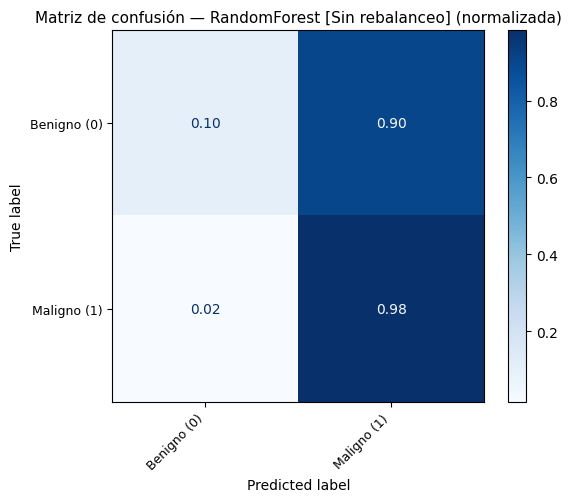

[INFO] Generando matrices de confusión — HistGradientBoosting [Sin rebalanceo]


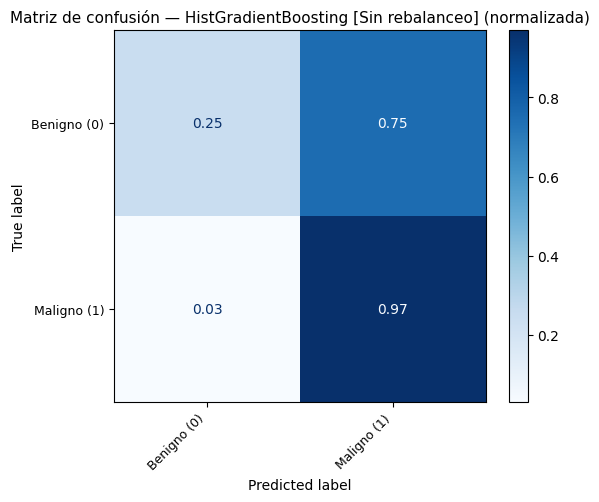

[INFO] Generando matrices de confusión — LogisticRegression [Sin rebalanceo]


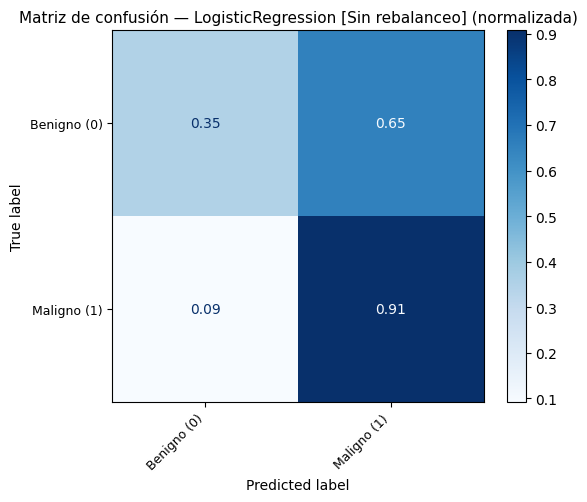

[INFO] Generando matrices de confusión — LinearSVM [Sin rebalanceo]


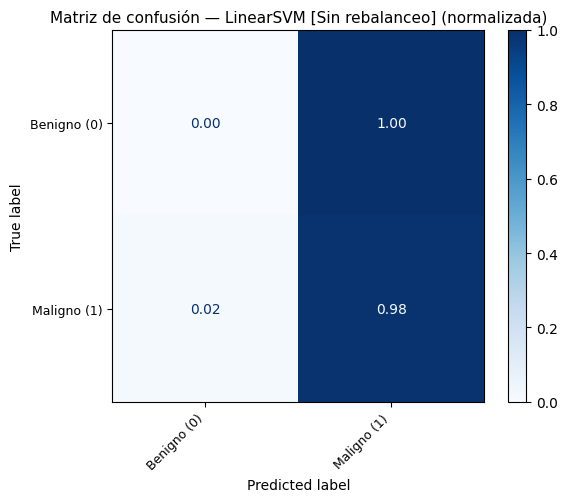

[INFO] Generando matrices de confusión — RandomForest (cw) [ClassWeight]


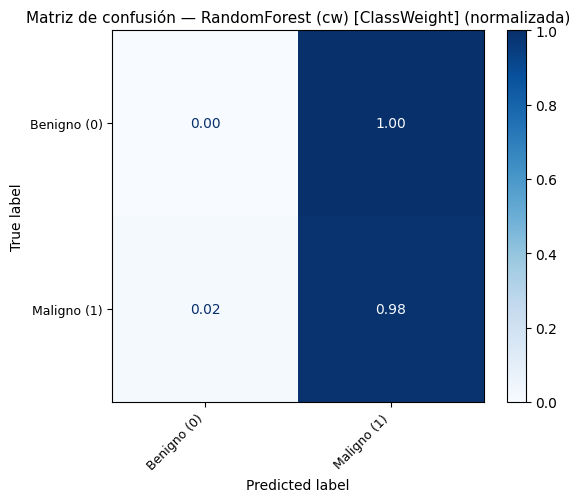

[INFO] Generando matrices de confusión — HistGradientBoosting (cw) [ClassWeight]


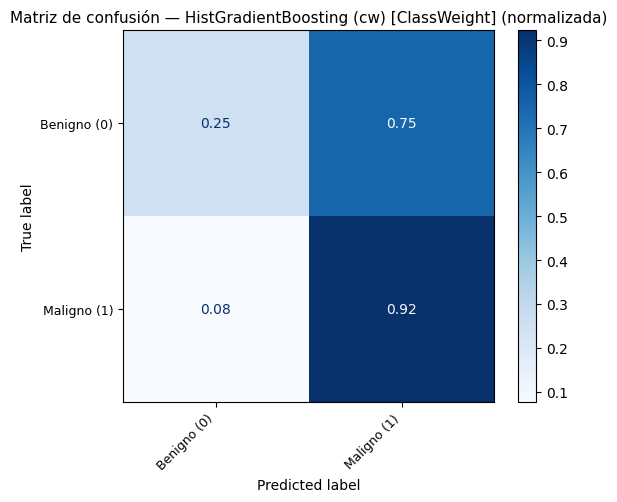

[INFO] Generando matrices de confusión — LogisticRegression (cw) [ClassWeight]


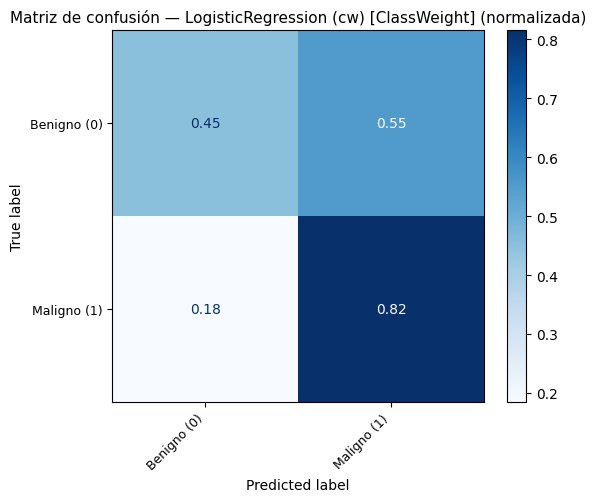

[INFO] Generando matrices de confusión — LinearSVM (cw) [ClassWeight]


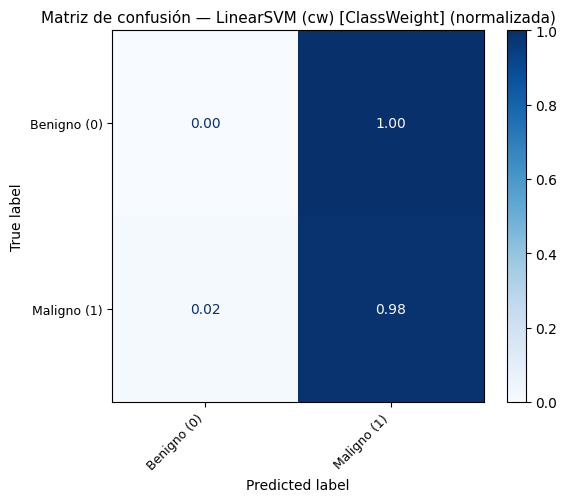

[INFO] Generando matrices de confusión — RandomForest + SMOTE [SMOTE]


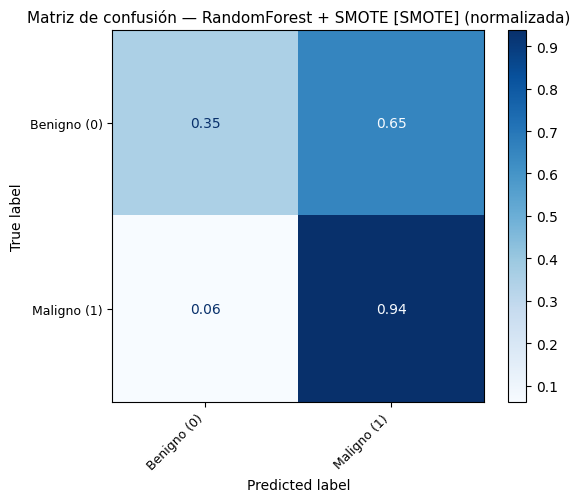

[INFO] Generando matrices de confusión — HistGradientBoosting + SMOTE [SMOTE]


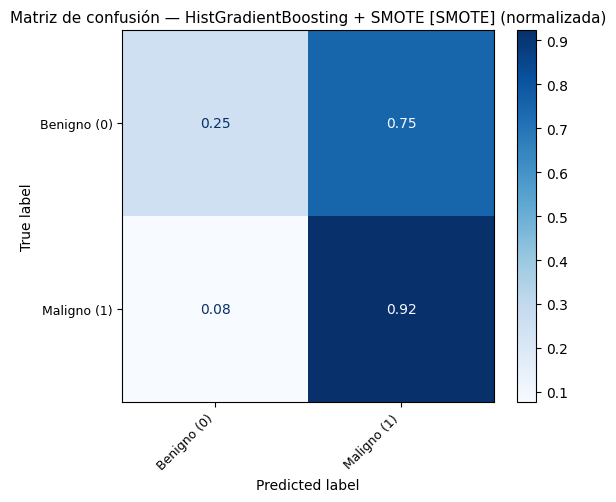

[INFO] Generando matrices de confusión — LogisticRegression + SMOTE [SMOTE]


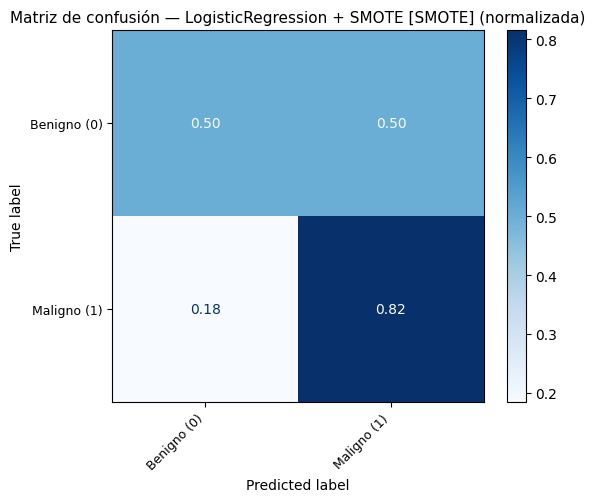

[INFO] Generando matrices de confusión — LinearSVM + SMOTE [SMOTE]


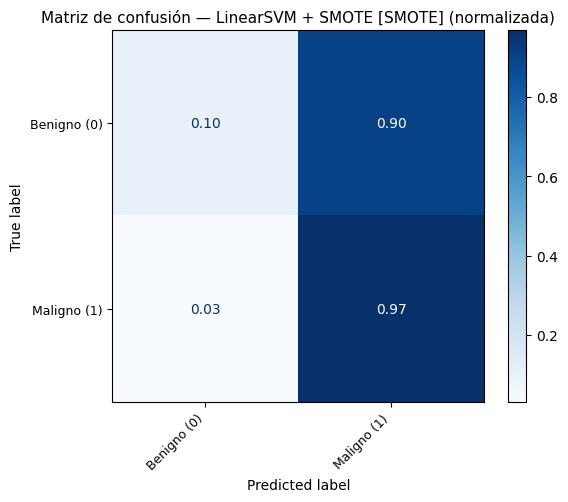

In [ ]:
# ============================================================
# Clasificación binaria Pancreas (PDAC vs Benigno)
# ============================================================

# Preparación de variables
X = X_logcpm_samples_by_features_pancreas.copy()
y = labels_pancreas.reindex(X.index)

# Transformación a etiquetas binarias: 1 = PDAC maligno y 0 = benigno
y_bin = y.map({
    "PancreasCancerMaligno": 1,
    "PancreasCancerBenigno": 0
}).astype(int)

print("[INFO] Clases disponibles (1=maligno, 0=benigno):")
print(y_bin.value_counts())

# Semilla y stratified fold con K = 5
RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "accuracy": "accuracy",
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "macro_f1": make_scorer(f1_score, average="macro"),
    "auc": make_scorer(roc_auc_score, needs_proba=True)
}

# Definición de modelos (sin rebalanceo y con SMOTE)
def build_models_baseline():
    return {
        "RandomForest": RandomForestClassifier(
            n_estimators=500, max_features="sqrt",
            random_state=RANDOM_STATE, n_jobs=-1
        ),
        "HistGradientBoosting": HistGradientBoostingClassifier(
            learning_rate=0.1, max_iter=300, random_state=RANDOM_STATE
        ),
        "LogisticRegression": SkPipeline(steps=[
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                solver="saga", penalty="l2", max_iter=5000,
                random_state=RANDOM_STATE, n_jobs=-1
            ))
        ]),
        "LinearSVM": SkPipeline(steps=[
            ("scaler", StandardScaler()),
            ("svm_cal", CalibratedClassifierCV(
                estimator=LinearSVC(
                    C=1.0, max_iter=5000, random_state=RANDOM_STATE
                ),
                method="sigmoid", cv=3
            ))
        ])
    }

def build_models_balanced():
    return {
        "RandomForest (cw)": RandomForestClassifier(
            n_estimators=500, max_features="sqrt",
            class_weight="balanced",
            random_state=RANDOM_STATE, n_jobs=-1
        ),
        "HistGradientBoosting (cw)": HistGradientBoostingClassifier(
            class_weight="balanced",
            learning_rate=0.1, max_iter=300,
            random_state=RANDOM_STATE
        ),
        "LogisticRegression (cw)": SkPipeline(steps=[
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                solver="saga", penalty="l2", class_weight="balanced",
                max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            ))
        ]),
        "LinearSVM (cw)": SkPipeline(steps=[
            ("scaler", StandardScaler()),
            ("svm_cal", CalibratedClassifierCV(
                estimator=LinearSVC(
                    class_weight="balanced",
                    C=1.0, max_iter=5000, random_state=RANDOM_STATE
                ),
                method="sigmoid", cv=3
            ))
        ])
    }

def build_models_smote():
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
    return {
        "RandomForest + SMOTE": ImbPipeline(steps=[
            ("smote", smote),
            ("clf", RandomForestClassifier(
                n_estimators=500, max_features="sqrt",
                random_state=RANDOM_STATE, n_jobs=-1
            ))
        ]),
        "HistGradientBoosting + SMOTE": ImbPipeline(steps=[
            ("smote", smote),
            ("clf", HistGradientBoostingClassifier(
                learning_rate=0.1, max_iter=300,
                random_state=RANDOM_STATE
            ))
        ]),
        "LogisticRegression + SMOTE": ImbPipeline(steps=[
            ("scaler", StandardScaler()),
            ("smote", smote),
            ("clf", LogisticRegression(
                solver="saga", penalty="l2",
                max_iter=5000, random_state=RANDOM_STATE, n_jobs=-1
            ))
        ]),
        "LinearSVM + SMOTE": ImbPipeline(steps=[
            ("scaler", StandardScaler()),
            ("smote", smote),
            ("svm_cal", CalibratedClassifierCV(
                estimator=LinearSVC(
                    C=1.0, max_iter=5000, random_state=RANDOM_STATE
                ),
                method="sigmoid", cv=3
            ))
        ])
    }

# Evaluación general de modelos
def eval_models(models, X, y, tag=""):
    rows = []
    for name, model in models.items():
        res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        row = {m: np.mean(res[f"test_{m}"]) for m in scoring}
        row["Modelo"] = name
        rows.append(row)
    df = pd.DataFrame(rows).sort_values("macro_f1", ascending=False).reset_index(drop=True)
    print(f"\n=== Resultados ({tag}) ===")
    print(df[["Modelo", "accuracy", "balanced_acc", "macro_f1", "auc"]].round(4))
    return df

# Evaluaciones
models_base = build_models_baseline()
models_cw = build_models_balanced()
models_smote = build_models_smote()

df_base = eval_models(models_base, X, y_bin, tag="Sin rebalanceo")
df_cw = eval_models(models_cw, X, y_bin, tag="Class weight = balanced")
df_smote = eval_models(models_smote, X, y_bin, tag="SMOTE")

# Matrices de confusión para TODOS los modelos/variantes (absoluta y normalizada)
os.makedirs("content", exist_ok=True)
classes = ["Benigno (0)", "Maligno (1)"]

# Obtiene predicciones OOF (CV k=5) con cross_val_predict y dibuja la matriz normalizada.
def plot_and_save_cm(model_name, model, X, y, tag):
    print(f"[INFO] Generando matrices de confusión — {model_name} [{tag}]")
    y_pred = cross_val_predict(model, X, y, cv=cv, method="predict", n_jobs=-1)

    # Normalizada
    cm_norm = confusion_matrix(y, y_pred, labels=[0,1], normalize="true")
    fig_norm, ax_norm = plt.subplots(figsize=(6,5))
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
    disp_norm.plot(ax=ax_norm, cmap="Blues", colorbar=True, values_format=".2f")
    ax_norm.set_title(f"Matriz de confusión — {model_name} [{tag}] (normalizada)", fontsize=11)
    plt.xticks(rotation=45, ha="right", fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    path_norm = f"content/cm_norm__{model_name.replace(' ','_')}__{tag.replace(' ','_')}.png"
    plt.savefig(path_norm, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig_norm)

    return path_norm

# Lo ejecuto para todos los modelos
all_summaries = []

for tag, models_dict in [
    ("Sin rebalanceo", models_base),
    ("ClassWeight", models_cw),
    ("SMOTE", models_smote),
]:
    for mname, model in models_dict.items():
        p_norm = plot_and_save_cm(mname, model, X, y_bin, tag)
        all_summaries.append({"Variante": tag, "Modelo": mname, "CM normalizada": p_norm})


### **Otras pruebas de rebalanceo**

Mencionar el uso de **Inteligencia Artificial** para la realización de estas pruebas, la intención es únicamente exploratoria, en caso de descubrir alguna técnica que funcione extremadamente bien, la idea es investigar más sobre ella y utilizarla.

En este caso directamente le he preguntado a *ChatGPT* que técnicas podía utilizar sobre este caso claro de desbalanceo y que me hiciera el código para Google Colab. (Se ha analizado por enciam el código y se ha ejecutado).

#### **SMOTE focalizado**

In [ ]:
def minority_ratio(y):
    c = Counter(y)
    maj = max(c, key=c.get)
    mino = min(c, key=c.get)
    return mino, c[mino], c[maj]

# ratio_target = proporción final (minorit./mayor.) tras SMOTE
def build_models_smote_focal(y, ratio_target=0.7, k_neighbors=3):     # Puedo ajustar el valor del ratio_target (igual conviene determinar un rango en vez de uno único)
    mino, n_min, n_maj = minority_ratio(y)
    smote_focal = SMOTE(
        sampling_strategy=ratio_target,
        k_neighbors=k_neighbors,
        random_state=42
    )
    return {
        "LR + SMOTE(focal)": ImbPipeline(steps=[
            ("scaler", StandardScaler()),
            ("smote", smote_focal),
            ("clf", LogisticRegression(
                solver="saga", penalty="l2",
                max_iter=5000, random_state=42, n_jobs=-1
            ))
        ]),
        "LinearSVM + SMOTE(focal)": ImbPipeline(steps=[
            ("scaler", StandardScaler()),
            ("smote", smote_focal),
            ("svm_cal", CalibratedClassifierCV(
                estimator=LinearSVC(C=1.0, max_iter=5000, random_state=42),
                method="sigmoid", cv=3
            ))
        ]),
        "RF + SMOTE(focal)": ImbPipeline(steps=[
            ("smote", smote_focal),
            ("clf", RandomForestClassifier(
                n_estimators=600, max_features="sqrt",
                random_state=42, n_jobs=-1
            ))
        ]),
        "HGB + SMOTE(focal)": ImbPipeline(steps=[
            ("smote", smote_focal),
            ("clf", HistGradientBoostingClassifier(
                learning_rate=0.1, max_iter=400, random_state=42
            ))
        ]),
    }


#### **SMOTE *duro* en la frontera: BorderlineSMOTE y SVMSMOTE**

In [ ]:
def build_models_borderline_and_svm_smote(k_neighbors=3):
    bsmote = BorderlineSMOTE(k_neighbors=k_neighbors, random_state=42)
    svms = SVMSMOTE(k_neighbors=k_neighbors, random_state=42)
    return {
        "LR + BorderlineSMOTE": ImbPipeline([
            ("scaler", StandardScaler()),
            ("smote", bsmote),
            ("clf", LogisticRegression(solver="saga", penalty="l2", max_iter=5000, random_state=42, n_jobs=-1))
        ]),
        "LR + SVMSMOTE": ImbPipeline([
            ("scaler", StandardScaler()),
            ("smote", svms),
            ("clf", LogisticRegression(solver="saga", penalty="l2", max_iter=5000, random_state=42, n_jobs=-1))
        ]),
    }


#### **Combinadas con under-sampling: SMOTE+Tomek y SMOTE+ENN**

In [ ]:
def build_models_smote_combo():
    st = SMOTETomek(random_state=42)
    se = SMOTEENN(random_state=42)
    return {
        "LR + SMOTETomek": ImbPipeline([
            ("scaler", StandardScaler()),
            ("combo", st),
            ("clf", LogisticRegression(solver="saga", penalty="l2", max_iter=5000, random_state=42, n_jobs=-1))
        ]),
        "LR + SMOTEENN": ImbPipeline([
            ("scaler", StandardScaler()),
            ("combo", se),
            ("clf", LogisticRegression(solver="saga", penalty="l2", max_iter=5000, random_state=42, n_jobs=-1))
        ]),
        "RF + SMOTETomek": ImbPipeline([
            ("combo", st),
            ("clf", RandomForestClassifier(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1))
        ]),
        "RF + SMOTEENN": ImbPipeline([
            ("combo", se),
            ("clf", RandomForestClassifier(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1))
        ]),
    }


#### **BalancedRandomForest / EasyEnsemble**

In [ ]:
def build_models_ensemble_imb():
    return {
        "BalancedRF": BalancedRandomForestClassifier(
            n_estimators=500, max_features="sqrt", random_state=42, n_jobs=-1
        ),
        "EasyEnsemble (AdaBoost)": EasyEnsembleClassifier(
            n_estimators=50, random_state=42, n_jobs=-1
        ),
    }


#### **Ajuste de umbral (por fold) — snippet listo**

In [ ]:
def cv_threshold_tuning(model, X, y, cv, prefer="f1"):    # prefer: 'f1' o 'recall'
    y_prob_oof = np.zeros_like(y, dtype=float)
    y = np.asarray(y)
    for tr, te in cv.split(X, y):
        m = clone(model)
        m.fit(X.iloc[tr], y[tr])
        y_prob_fold = m.predict_proba(X.iloc[te])[:,1]
        y_prob_tr = m.predict_proba(X.iloc[tr])[:,1]
        p, r, thr = precision_recall_curve(y[tr], y_prob_tr)
        f1 = 2*p*r/(p+r+1e-12)
        if prefer == "f1":
            t_best = thr[np.argmax(f1[:-1])]
        else:
            mask = r[:-1] >= 0.85                         # Puedo modificarlo para probar otros valores, pero más elevado que 0.85 me parece excesivo
            t_best = thr[np.argmax(f1[:-1][mask])] if mask.any() else thr[np.argmax(f1[:-1])]
        y_prob_oof[te] = y_prob_fold
    return y_prob_oof

# Ejemplo de uso:
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_lr_smote_focal = build_models_smote_focal(y_bin, ratio_target=0.7)["LR + SMOTE(focal)"]

y_prob_oof = cv_threshold_tuning(model_lr_smote_focal, X, y_bin, cv5, prefer="f1")
best_thresh = 0.5
ps, rs, ths = precision_recall_curve(y_bin, y_prob_oof)
f1s = 2*ps*rs/(ps+rs+1e-12)
best_thresh = ths[np.argmax(f1s[:-1])]

y_pred_oof = (y_prob_oof >= best_thresh).astype(int)
print("F1(macro):", f1_score(y_bin, y_pred_oof, average="macro"))


F1(macro): 0.6697746697746698


In [ ]:
models_smote_focal = build_models_smote_focal(y_bin, ratio_target=0.7, k_neighbors=3)
models_border_svm = build_models_borderline_and_svm_smote(k_neighbors=3)
models_smote_combo = build_models_smote_combo()
models_imb_ens = build_models_ensemble_imb()

for tag, mdict in [
    ("SMOTE focalizado", models_smote_focal),
    ("Borderline/SVM-SMOTE", models_border_svm),
    ("SMOTE+Tomek/ENN", models_smote_combo),
    ("Imbalanced Ensembles", models_imb_ens),
]:
    _ = eval_models(mdict, X, y_bin, tag=tag)  # uso la función eval_models definida anteriormente



=== Resultados (SMOTE focalizado) ===
                     Modelo  accuracy  balanced_acc  macro_f1  auc
0         RF + SMOTE(focal)    0.8000        0.6269    0.6197  NaN
1         LR + SMOTE(focal)    0.7412        0.6231    0.6091  NaN
2        HGB + SMOTE(focal)    0.7647        0.6212    0.6031  NaN
3  LinearSVM + SMOTE(focal)    0.7765        0.5423    0.5154  NaN

=== Resultados (Borderline/SVM-SMOTE) ===
                 Modelo  accuracy  balanced_acc  macro_f1  auc
0         LR + SVMSMOTE    0.7412        0.6404    0.6190  NaN
1  LR + BorderlineSMOTE    0.7176        0.6077    0.5882  NaN

=== Resultados (SMOTE+Tomek/ENN) ===
            Modelo  accuracy  balanced_acc  macro_f1  auc
0  RF + SMOTETomek    0.8235        0.6942    0.7060  NaN
1  LR + SMOTETomek    0.7294        0.6500    0.6205  NaN
2    LR + SMOTEENN    0.5059        0.5558    0.4661  NaN
3    RF + SMOTEENN    0.2824        0.4962    0.2403  NaN

=== Resultados (Imbalanced Ensembles) ===
                    Mod